# LiDAR Virtual Lab tutorial

Welcome to the tutorial for the LiDAR Virtual Lab. In this tutorial, we will introduce how to generate geospatial data products of ecosystem structure from LiDAR point cloud using Notebook-as-a-VRE (NaaVRE).

First, let's get some background of what is ecosystem structure and LiDAR data. 

## 1. What is ecosystem structure?

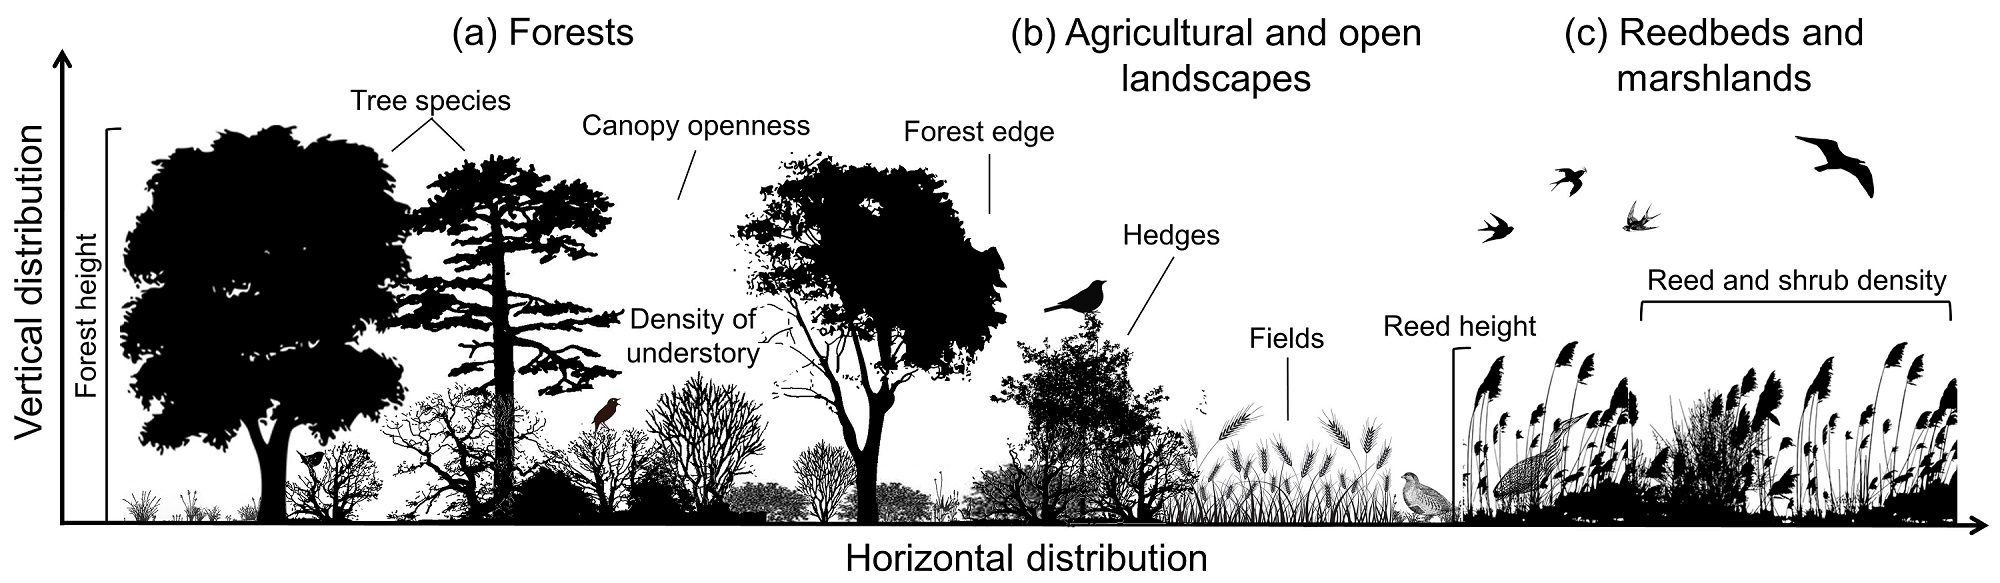

The vertical and horizontal distribution of plants influences habitat structure and 3D characteristics of vegetation for animals. Illustrated are examples for (a) forests, (b) agricultural and open landscapes, and (c) reedbeds and marshlands. The height, openness and density of vegetation as well as specific habitat features (e.g. tree species, hedges etc.) are key aspects of animal habitat and space use. 

Image credit: Kissling et al. 2017 Research Ideas and Outcomes https://doi.org/10.3897/rio.3.e14939

## 2. What is LiDAR?

LiDAR, or Light Detection And Ranging, is one active remote sensing method that can be used to map structure, including vegetation height, density, and other characteristics across a region. LiDAR directly measures the height and density of vegetation on the groun,d making it an ideal tool for scientists studying vegetation over large areas.

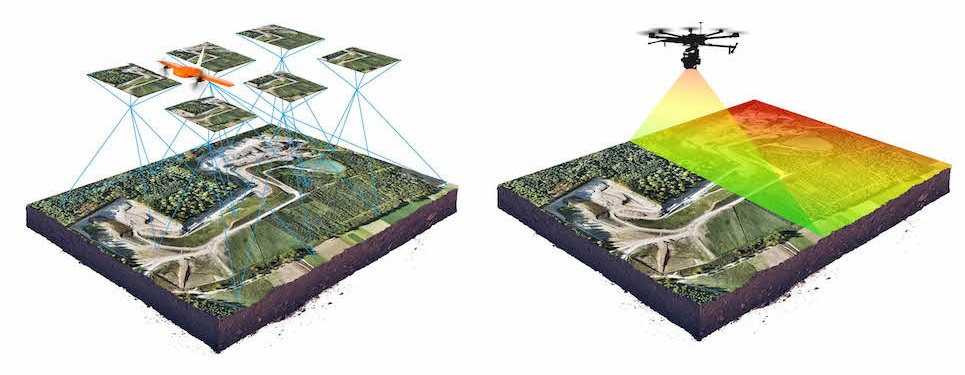

# 3. Laserfarm workflow
### A high-throughput workflow for quantifying ecosystem structure from airborne LiDAR

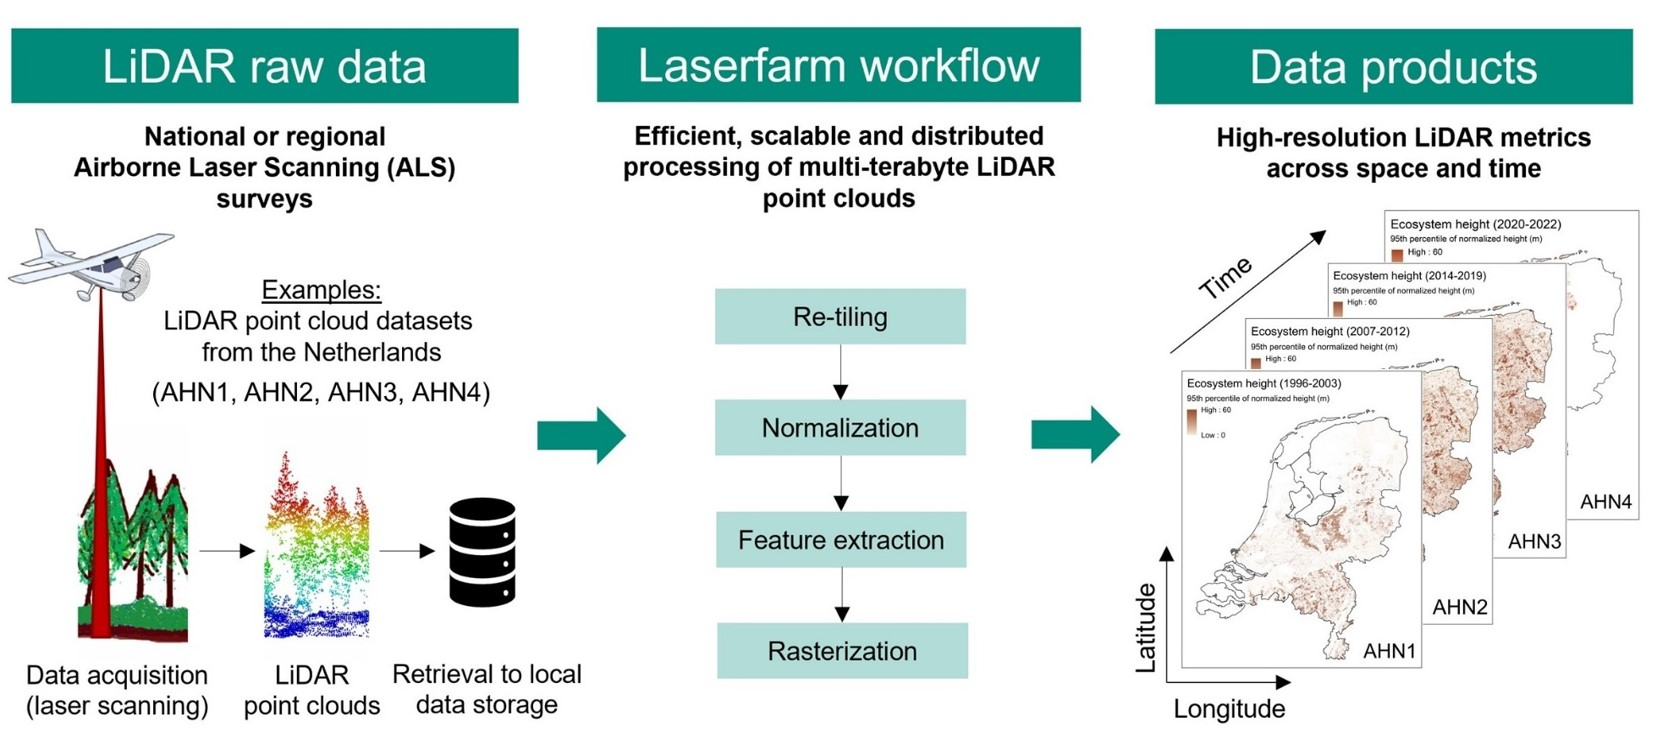

The Laserfarm workflow enables the efficient, scalable and distributed processing of multi-terabyte Light Detection And Ranging (LiDAR) point clouds from national and regional airborne laser scanning (ALS) surveys into raster layers of ecosystem structure. The Laserfarm workflow is exemplified with a country-wide LiDAR point cloud dataset from the Netherlands (AHN).

## 3.1 Main steps of Laserfarm workflow

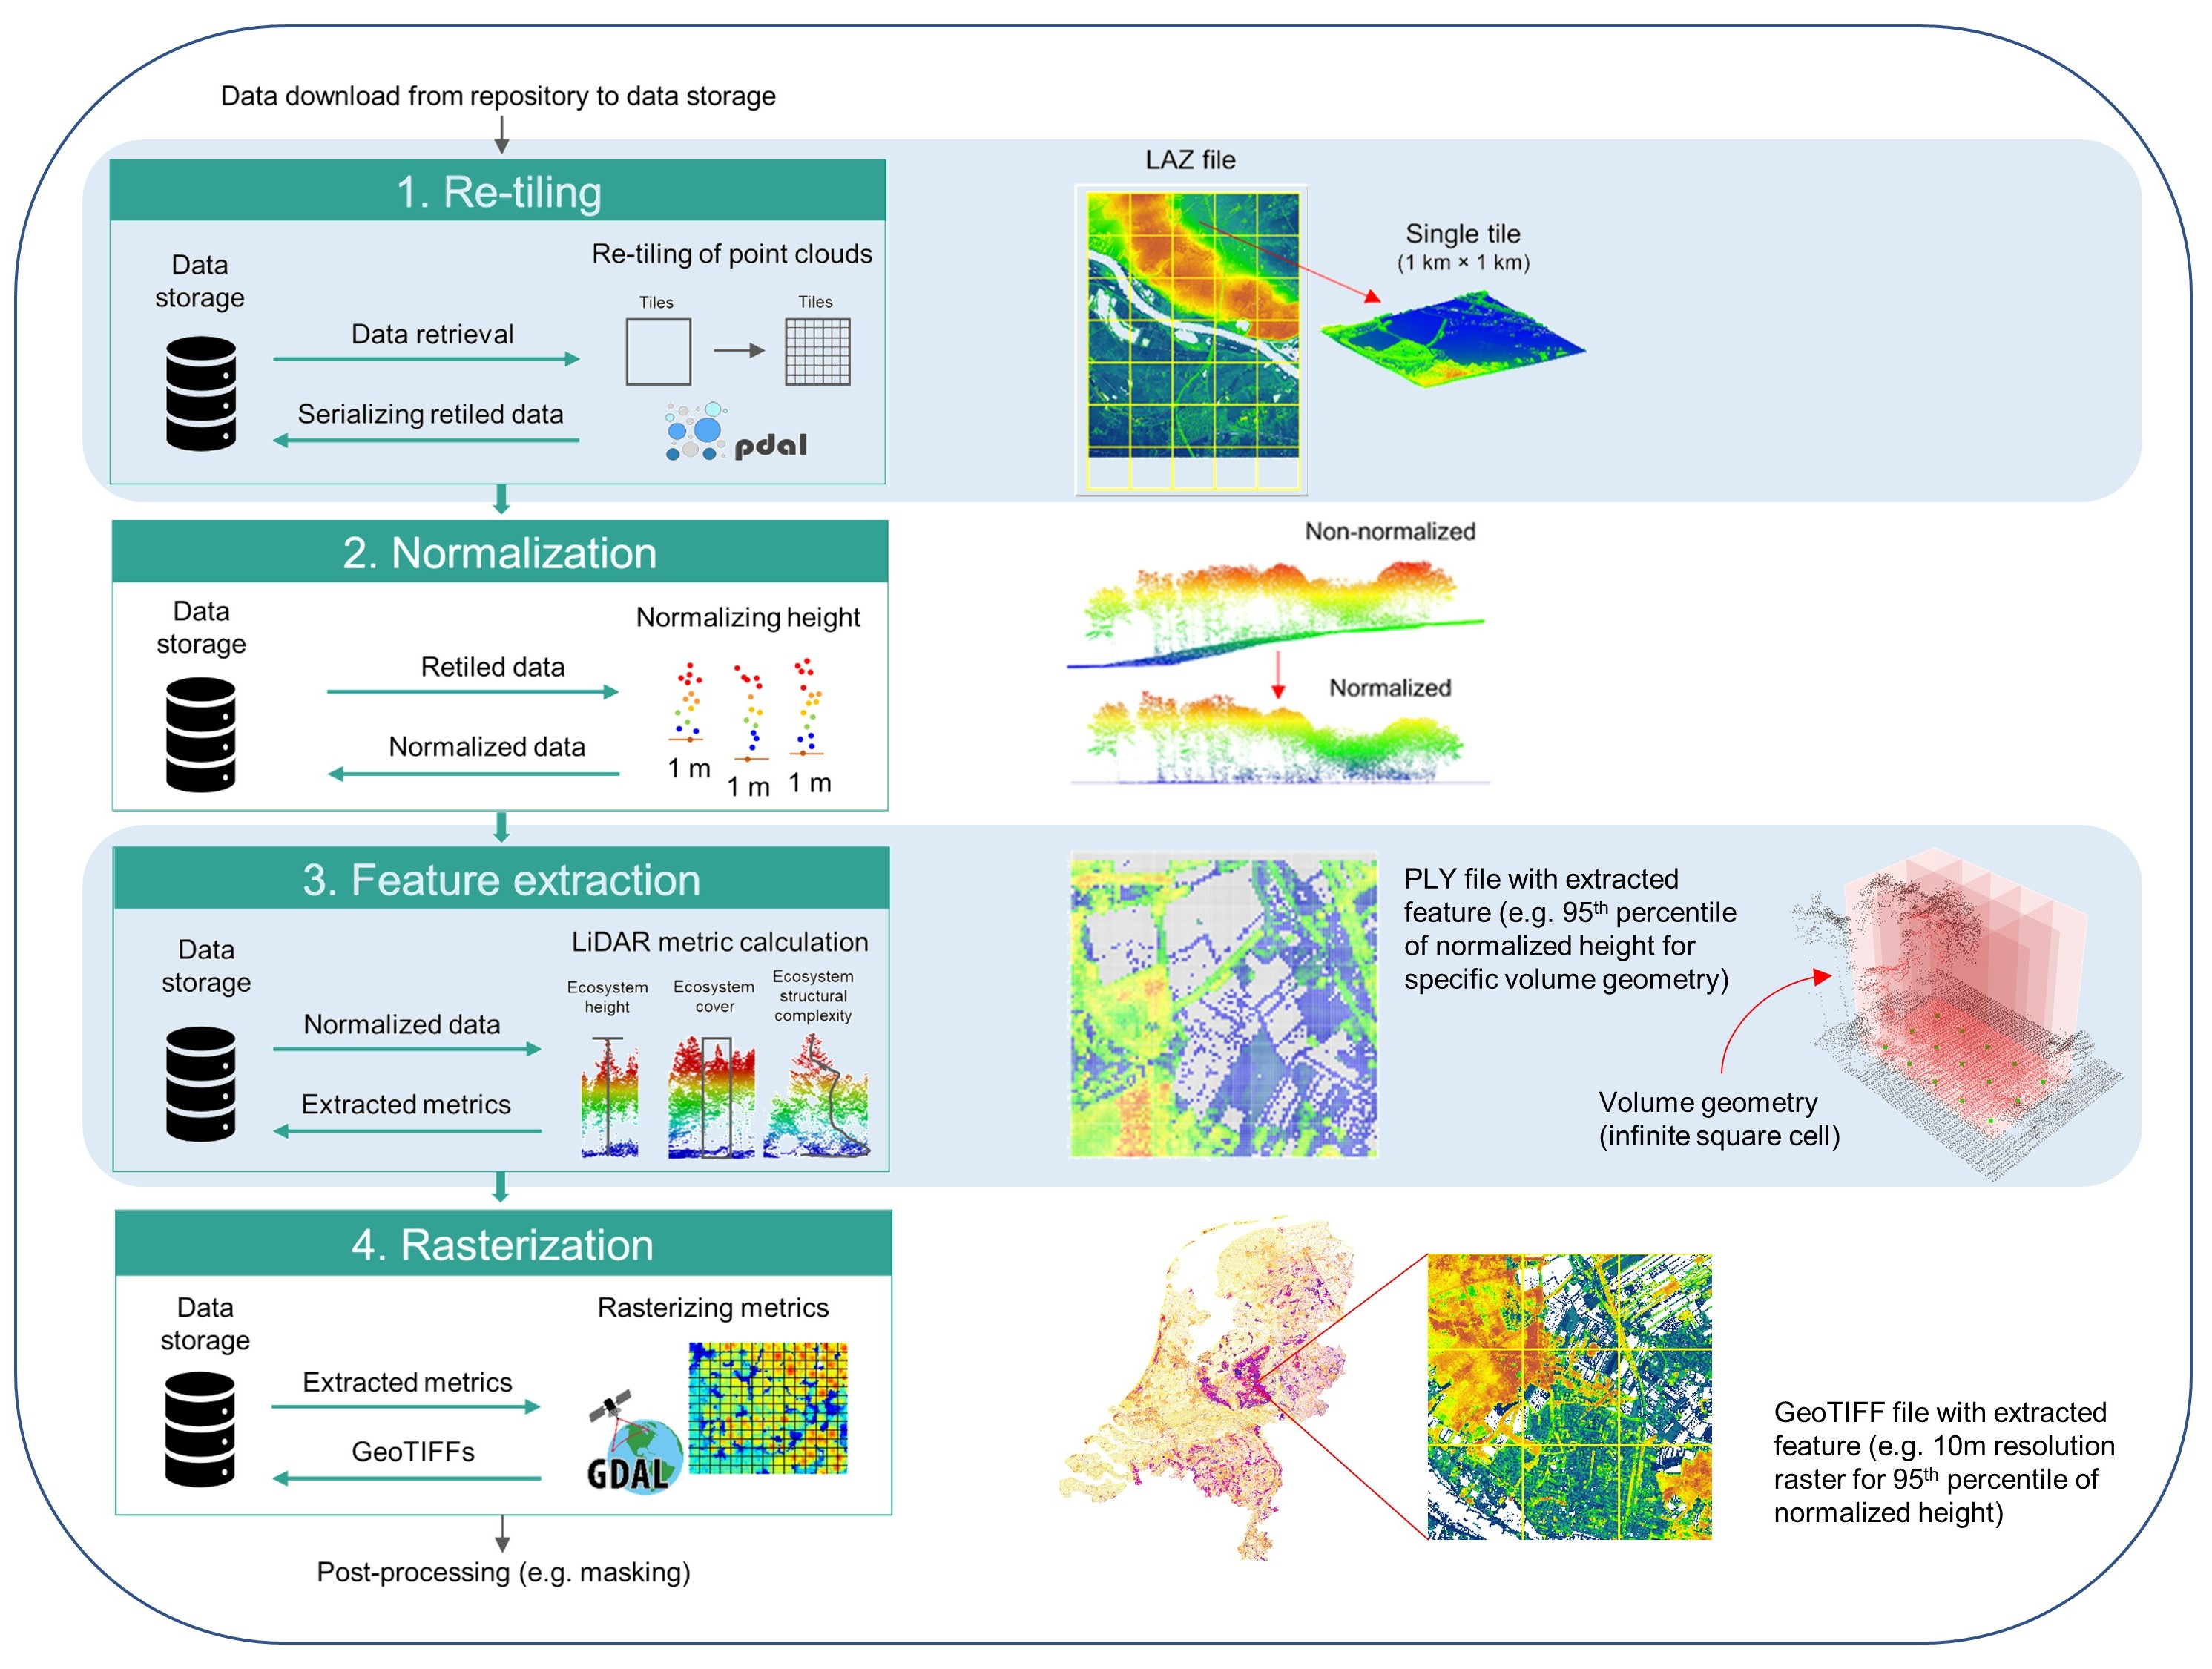

#### Each step can be containerized using NaaVRE and the workflow can be managed and executed within Jupyter environment.

Things can be modified within the workflow:

* Input data (point cloud from different area with various landscapes/ecosystems)

* The resolution of the final data products (how detail each pixel represents in the generated GeoTIFF layer)

* Define which feature(s) to be extracted for different applications (e.g. vegetation height, vegetation cover, vegetation density within a certain height range)


## 3.2 Explanation of the script used in the Laserfarm workflow

### User parameters

Defines the parameters that can be set by users when executing the workflow.

In [ ]:
# (DO NOT containerize this cell)

# Data handling parameters
param_minio_endpoint = 'scruffy.lab.uvalight.net:9000'
param_minio_public_bucket = 'naa-vre-public'
param_minio_public_dataset_prefix = 'vl-laserfarm/medium_ameland/ahn3'
param_minio_user_bucket = 'naa-vre-user-data'
param_minio_user_prefix = '' # personal folder, see tutorial (should be your username)
secret_minio_access_key = ''  # Your access key, see tutorial
secret_minio_secret_key = ''  # Your secret key, see tutorial

# Laserfarm parameters
param_feature_name = 'perc_95_normalized_height'
param_validate_precision = '0.001'
param_tile_mesh_size = '10.'
param_filter_type = 'select_equal'
param_attribute = 'raw_classification'
param_min_x = '-113107.81'  # EPSG:28992
param_max_x = '398892.19'  # EPSG:28992
param_min_y = '214783.87'  # EPSG:28992
param_max_y = '726783.87'  # EPSG:28992
param_n_tiles_side = '512'
param_apply_filter_value = '1'
param_laz_compression_factor = '7'
param_max_filesize_mb = '80'  # desired max file size (in MiB)


### Global configuration

The following variable are used throughout the code. They are intended to be edited by developers who provided the notebook.

In [ ]:
# (DO NOT containerize this cell)

conf_local_tmp = '/tmp/data'
conf_local_path_raw = os.path.join(conf_local_tmp, 'raw')
conf_local_path_split = os.path.join(conf_local_tmp, 'split')
conf_local_path_retiled = os.path.join(conf_local_tmp, 'retiled')
conf_local_path_targets = os.path.join(conf_local_tmp, 'targets')
conf_local_path_geotiff = os.path.join(conf_local_tmp, 'geotiff')
conf_local_path_figures = os.path.join(conf_local_tmp, 'figures')

## Workflow steps

### (1) Fetch laz files from remote storage

This cell retrieves `.laz` files from the remote MinIO storage.

In [ ]:
# S1 Fetch laz files
# base image: vanilla

os.makedirs(conf_local_path_raw, exist_ok=True)
raw_laz_files = []

minio_client = Minio(param_minio_endpoint, secure=True)
objects = minio_client.list_objects(
    param_minio_public_bucket, prefix=param_minio_public_dataset_prefix
    )
for obj in objects:
    if obj.object_name.upper().endswith('.LAZ'):
        laz_file = os.path.join(
            conf_local_path_raw, obj.object_name.split('/')[-1]
            )
        if not os.path.isfile(laz_file):
            print(
                f'Downloading {param_minio_public_bucket}:{obj.object_name} to {laz_file}'
                )
            minio_client.fget_object(
                param_minio_public_bucket, obj.object_name, laz_file
                )
        else:
            print(
                f'Skipping download of {param_minio_public_bucket}:{obj.object_name} because {laz_file} already exists'
                )
        raw_laz_files.append(laz_file)

print(raw_laz_files)

### (2) Split big files

This step splits big laz files into smaller files. This is useful when the original files are too large for the VMs used for the processing. If the VMs have enough memory to hold the laz files, this step can be skipped.

In [ ]:
# S2 Split big laz
# base image: laserfarm

import os

def save_chunk_to_laz_file(
        in_filename,
        out_filename,
        offset,
        n_points
        ):
    """ Read points from a LAS/LAZ file and write them to a new file. """
    with laspy.open(in_filename) as in_file:
        with laspy.open(
                out_filename,
                mode="w",
                header=in_file.header
                ) as out_file:
            in_file.seek(offset)
            points = in_file.read_points(n_points)
            out_file.write_points(points)
    return out_filename


def split_strategy(filename, max_filesize, dest_dir=None):
    """ Set up splitting strategy for a LAS/LAZ file. """
    with laspy.open(filename) as f:
        bytes_per_point = (
                f.header.point_format.num_standard_bytes +
                f.header.point_format.num_extra_bytes
        )
        n_points = f.header.point_count
    n_points_target = int(
        max_filesize * int(param_laz_compression_factor) / bytes_per_point
        )
    stem, ext = os.path.splitext(filename)
    if dest_dir is not None:
        stem = os.path.join(dest_dir, os.path.basename(stem))
    return [
        (filename, f"{stem}-{n}{ext}", offset, n_points_target)
        for n, offset in enumerate(range(0, n_points, n_points_target))
        ]


os.makedirs(conf_local_path_split, exist_ok=True)
split_laz_files = []

for raw_file in raw_laz_files:
    inps = split_strategy(
        raw_file,
        int(param_max_filesize_mb) * 2 ** 20,
        dest_dir=conf_local_path_split,
        )
    print(f'Splitting {raw_file} into {len(inps)} files:')
    for inp in inps:
        split_file = inp[1]
        if not os.path.isfile(split_file):
            print(f'  writing {split_file}')
            save_chunk_to_laz_file(*inp)
        else:
            print(f' skipping {split_file} because it already exists')
        split_laz_files.append(split_file)

print(split_laz_files)

### (3) Retile laz files

This step splits the laz files into small tiles that can be easily processed for the following steps.

In [ ]:
# S3 Retile laz files
# base image: laserfarm

grid_retile = {
    'min_x': float(param_min_x),
    'max_x': float(param_max_x),
    'min_y': float(param_min_y),
    'max_y': float(param_max_y),
    'n_tiles_side': int(param_n_tiles_side),
    }

retiling_input = {
    'setup_local_fs': {
        'input_folder': conf_local_path_split,
        'output_folder': conf_local_path_retiled,
        },
    'set_grid': grid_retile,
    'split_and_redistribute': {},
    'validate': {},
    }

os.makedirs(conf_local_path_retiled, exist_ok=True)
tiles = []

for file in split_laz_files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    retile_record_filename = os.path.join(
        conf_local_path_retiled,
        f'{base_name}_retile_record.js',
        )
    if not os.path.isfile(retile_record_filename):
        print(f'Retiling {file}')
        retiler = Retiler(file, label=file).config(retiling_input)
        retiler.run()
    else:
        print(
            f'Skipping retiling of {file} because {retile_record_filename} already exists'
            )
    # load filenames from retile record
    with open(retile_record_filename, 'r') as f:
        retile_record = json.load(f)
    tiles += retile_record['redistributed_to']

print(tiles)

### (4) Unique tiles

Ensure that the list of tiles contains no duplicates. This is necessary because the above step might return duplicates. If no splitting is used, this cell can be merged with the above one. 

In [ ]:
# S4 Unique tiles
# base image: vanilla

unique_tiles = list(set(tiles))

print(unique_tiles)

### (5) Extract features from tiles

Run the feature extraction for each tile. The features are extracted using [laserchicken](https://github.com/eEcoLiDAR/laserchicken).

In [ ]:
# S5 Extract features
# base image: laserfarm

feature_files = []

for i, tile in enumerate(unique_tiles):
    grid_feature = {
        'min_x': float(param_min_x),
        'max_x': float(param_max_x),
        'min_y': float(param_min_y),
        'max_y': float(param_max_y),
        'n_tiles_side': int(param_n_tiles_side),
        }

    feature_extraction_input = {
        'setup_local_fs': {
            'input_folder': conf_local_path_retiled,
            'output_folder': conf_local_path_targets,
            },
        'load': {'attributes': [param_attribute]},
        'normalize': 1, #Normalization step is merged into the feature extraction step here
        'apply_filter': {
            'filter_type': param_filter_type,
            'attribute': param_attribute,
            'value': [int(param_apply_filter_value)],
            #ground surface (2), water (9), buildings (6), artificial objects (26), vegetation (?), and unclassified (1)
            },
        'generate_targets': {
            'tile_mesh_size': float(param_tile_mesh_size),
            'validate': True,
            'validate_precision': float(param_validate_precision),
            **grid_feature
            },
        'extract_features': {
            'feature_names': [param_feature_name],
            'volume_type': 'cell',
            'volume_size': float(param_tile_mesh_size),
            },
        'export_targets': {
            'attributes': [param_feature_name],
            'multi_band_files': False,
            },
        }
    idx = (tile.split('_')[1:])

    target_file = os.path.join(
        conf_local_path_targets, param_feature_name, tile + '.ply'
        )
    print(target_file)

    if not os.path.isfile(target_file):
        print(f'Extracting features from {tile} ({i + 1} of {len(unique_tiles)})')
        processing = DataProcessing(tile, tile_index=idx, label=tile).config(
            feature_extraction_input
            )
        processing.run()
    else:
        print(
            f'Skipping features extraction for {tile} ({i + 1} of {len(unique_tiles)}) because {target_file} already exists'
            )

    feature_files.append(target_file)

print(feature_files)

### (6) Save GeoTIFF

Generate a GeoTIFF containing the extracted features. This merges all tiles into one file. 

In [ ]:
# S6 Save GeoTIFF
# base image: laserfarm

print(feature_files)

geotiff_export_input = {
    'setup_local_fs': {
        'input_folder': conf_local_path_targets,
        'output_folder': conf_local_path_geotiff,
        },
    'parse_point_cloud': {},
    'data_split': {
        'xSub': 1,
        'ySub': 1,
        },
    'create_subregion_geotiffs': {
        'output_handle': 'geotiff'
        },
    }

writer = (
    GeotiffWriter(
        input_dir=param_feature_name,
        bands=param_feature_name,
        label=param_feature_name,
        )
    .config(geotiff_export_input)
    )
writer.run()

geotiff_file_local = os.path.join(
    conf_local_path_geotiff, f'geotiff_TILE_000_BAND_{param_feature_name}.tif',
    )
geotiff_file_remote = os.path.join(
    param_minio_user_prefix, param_minio_public_dataset_prefix,
    os.path.relpath(geotiff_file_local, conf_local_tmp),
    )
print(f'Uploading {geotiff_file_local} to {param_minio_user_bucket}/{geotiff_file_remote}')

mc = Minio(
    endpoint=param_minio_endpoint,
    access_key=secret_minio_access_key,
    secret_key=secret_minio_secret_key,
    )
mc.fput_object(
    bucket_name=param_minio_user_bucket,
    file_path=geotiff_file_local,
    object_name=geotiff_file_remote,
    )

### (7) Create figures for visualization

In [ ]:
# S7 Figures
# base image: vanilla

import matplotlib.pyplot as plt
import rasterio
import rasterio.plot as rp

src = rasterio.open(geotiff_file_local)

os.makedirs(conf_local_path_figures, exist_ok=True)

ax = plt.gca()
rio_plot = rp.show((src, 1), interpolation='none', ax=ax)
img = rio_plot.get_images()[0]
cb = plt.colorbar(img, ax=ax)
cb.set_label(f'{param_feature_name}')
plt.xlabel('EPSG:28992 X [m]')
plt.ylabel('EPSG:28992 Y [m]')
plt.show()
map_file_local = os.path.join(
    conf_local_path_figures, f'{param_feature_name}_map.pdf',
    )
map_file_remote = os.path.join(
    param_minio_user_prefix, param_minio_public_dataset_prefix,
    os.path.relpath(map_file_local, conf_local_tmp),
    )
plt.savefig(map_file_local)

rp.show_hist(
    src,
    bins=50,
    lw=0.0,
    stacked=False,
    alpha=0.3,
    histtype='stepfilled',
    title="Histogram",
    )
plt.show()
histogram_file_local = os.path.join(
    conf_local_path_figures, f'{param_feature_name}_histogram.pdf',
    )
histogram_file_remote = os.path.join(
    param_minio_user_prefix, param_minio_public_dataset_prefix,
    os.path.relpath(histogram_file_local, conf_local_tmp),
    )
plt.savefig(histogram_file_local)

mc = Minio(
    endpoint=param_minio_endpoint,
    access_key=secret_minio_access_key,
    secret_key=secret_minio_secret_key,
    )
print(f'Uploading {map_file_local} to {param_minio_user_bucket}/{map_file_remote}')
mc.fput_object(file_path=map_file_local, bucket_name=param_minio_user_bucket, object_name=map_file_remote)


# Exercise 

This exercise aims to 

(1) understand how Laserfarm workflow works;

(2) extract some LiDAR metrics for quantifying vegetation structure using NaaVRE; and

(3) build your own workflow and explore the output.

We will use Laserfarm workflow (https://laserfarm.readthedocs.io/en/latest/) build on Laserchicken software (https://laserchicken.readthedocs.io/en/latest/) to process airborne laser scanning data. Check out this story map (https://storymaps.arcgis.com/stories/0c4aaf1d5c2645349897df701af6d051) to have an initial idea of what is LiDAR and how does it link with ecosystem structure.

Documentation about NaaVRE: https://naavre.net/

**Sign in NaaVRE by following the instructions: https://naavre.net/docs/tutorials/**

Data storage on Minio: https://scruffy.lab.uvalight.net:9001/browser

**Login Laserfarm Virtual Lab: https://beta.naavre.net/vreapp/vl/laserfarm**

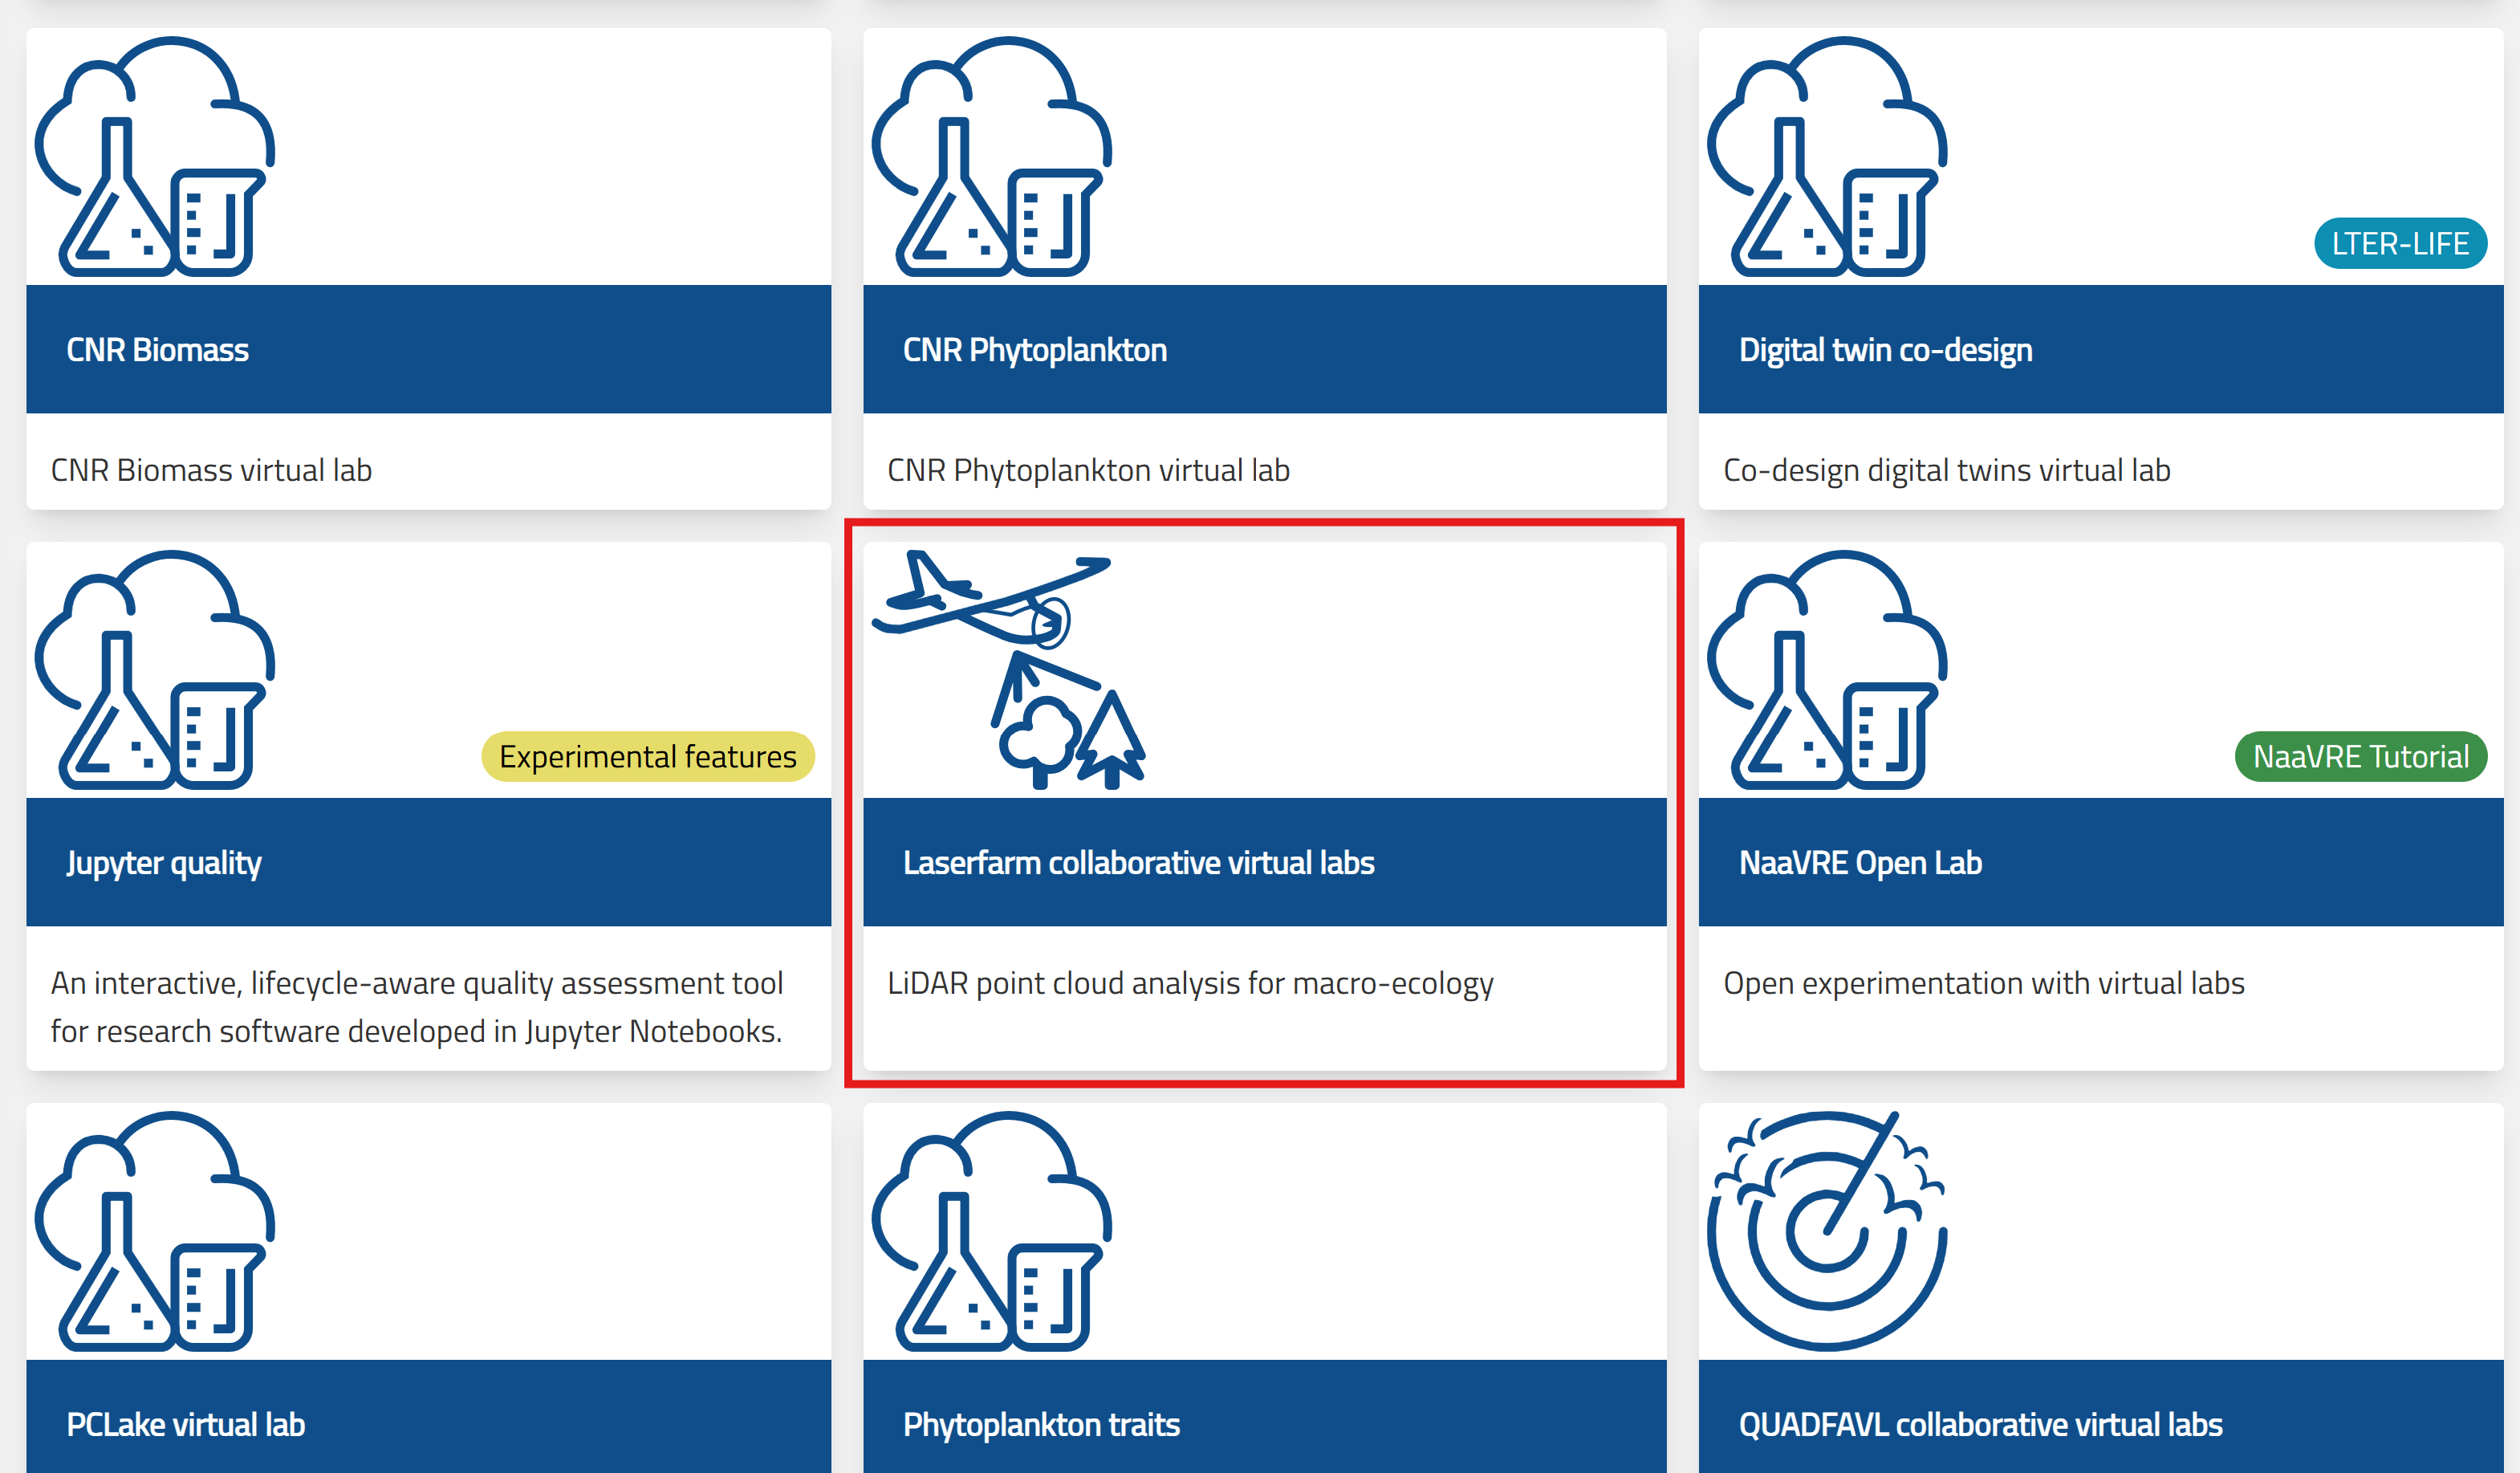

You can start an instance

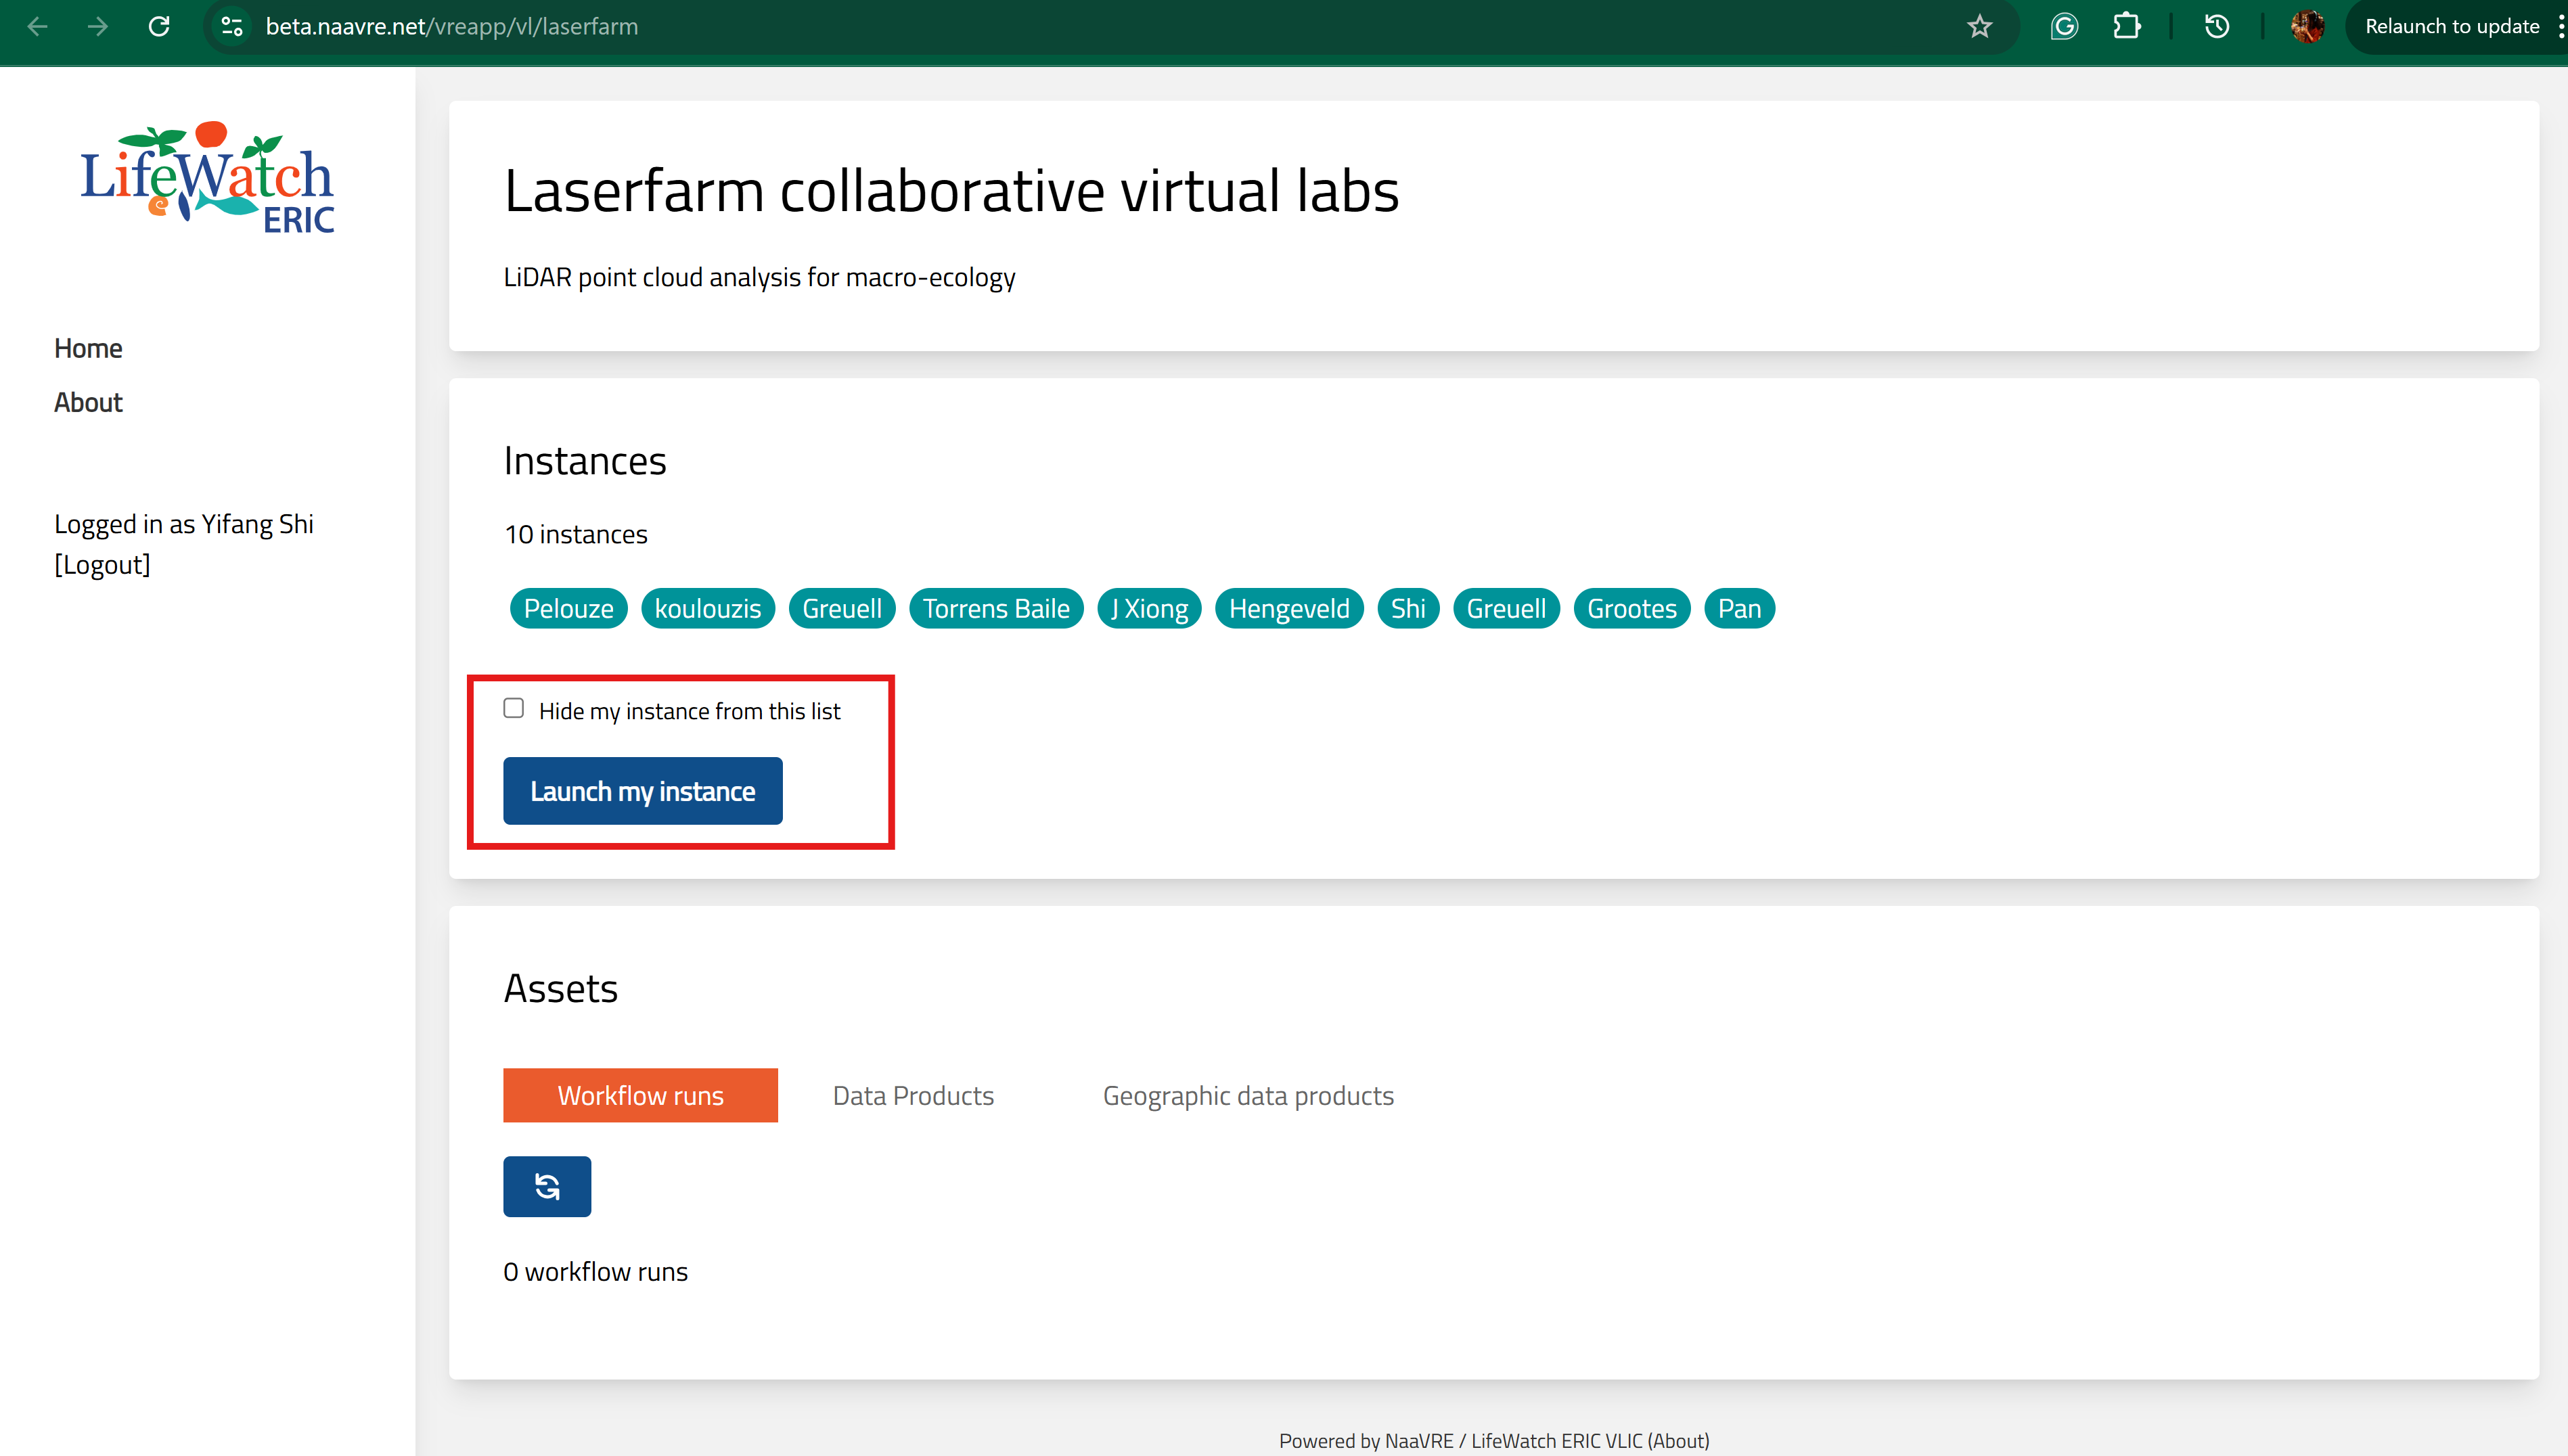


You will be directed to the landing page with an introduction to the Virtual Lab. You can also find the Jupyter Notebook about the Laserfarm workflow, which has already been implemented in your workspace.

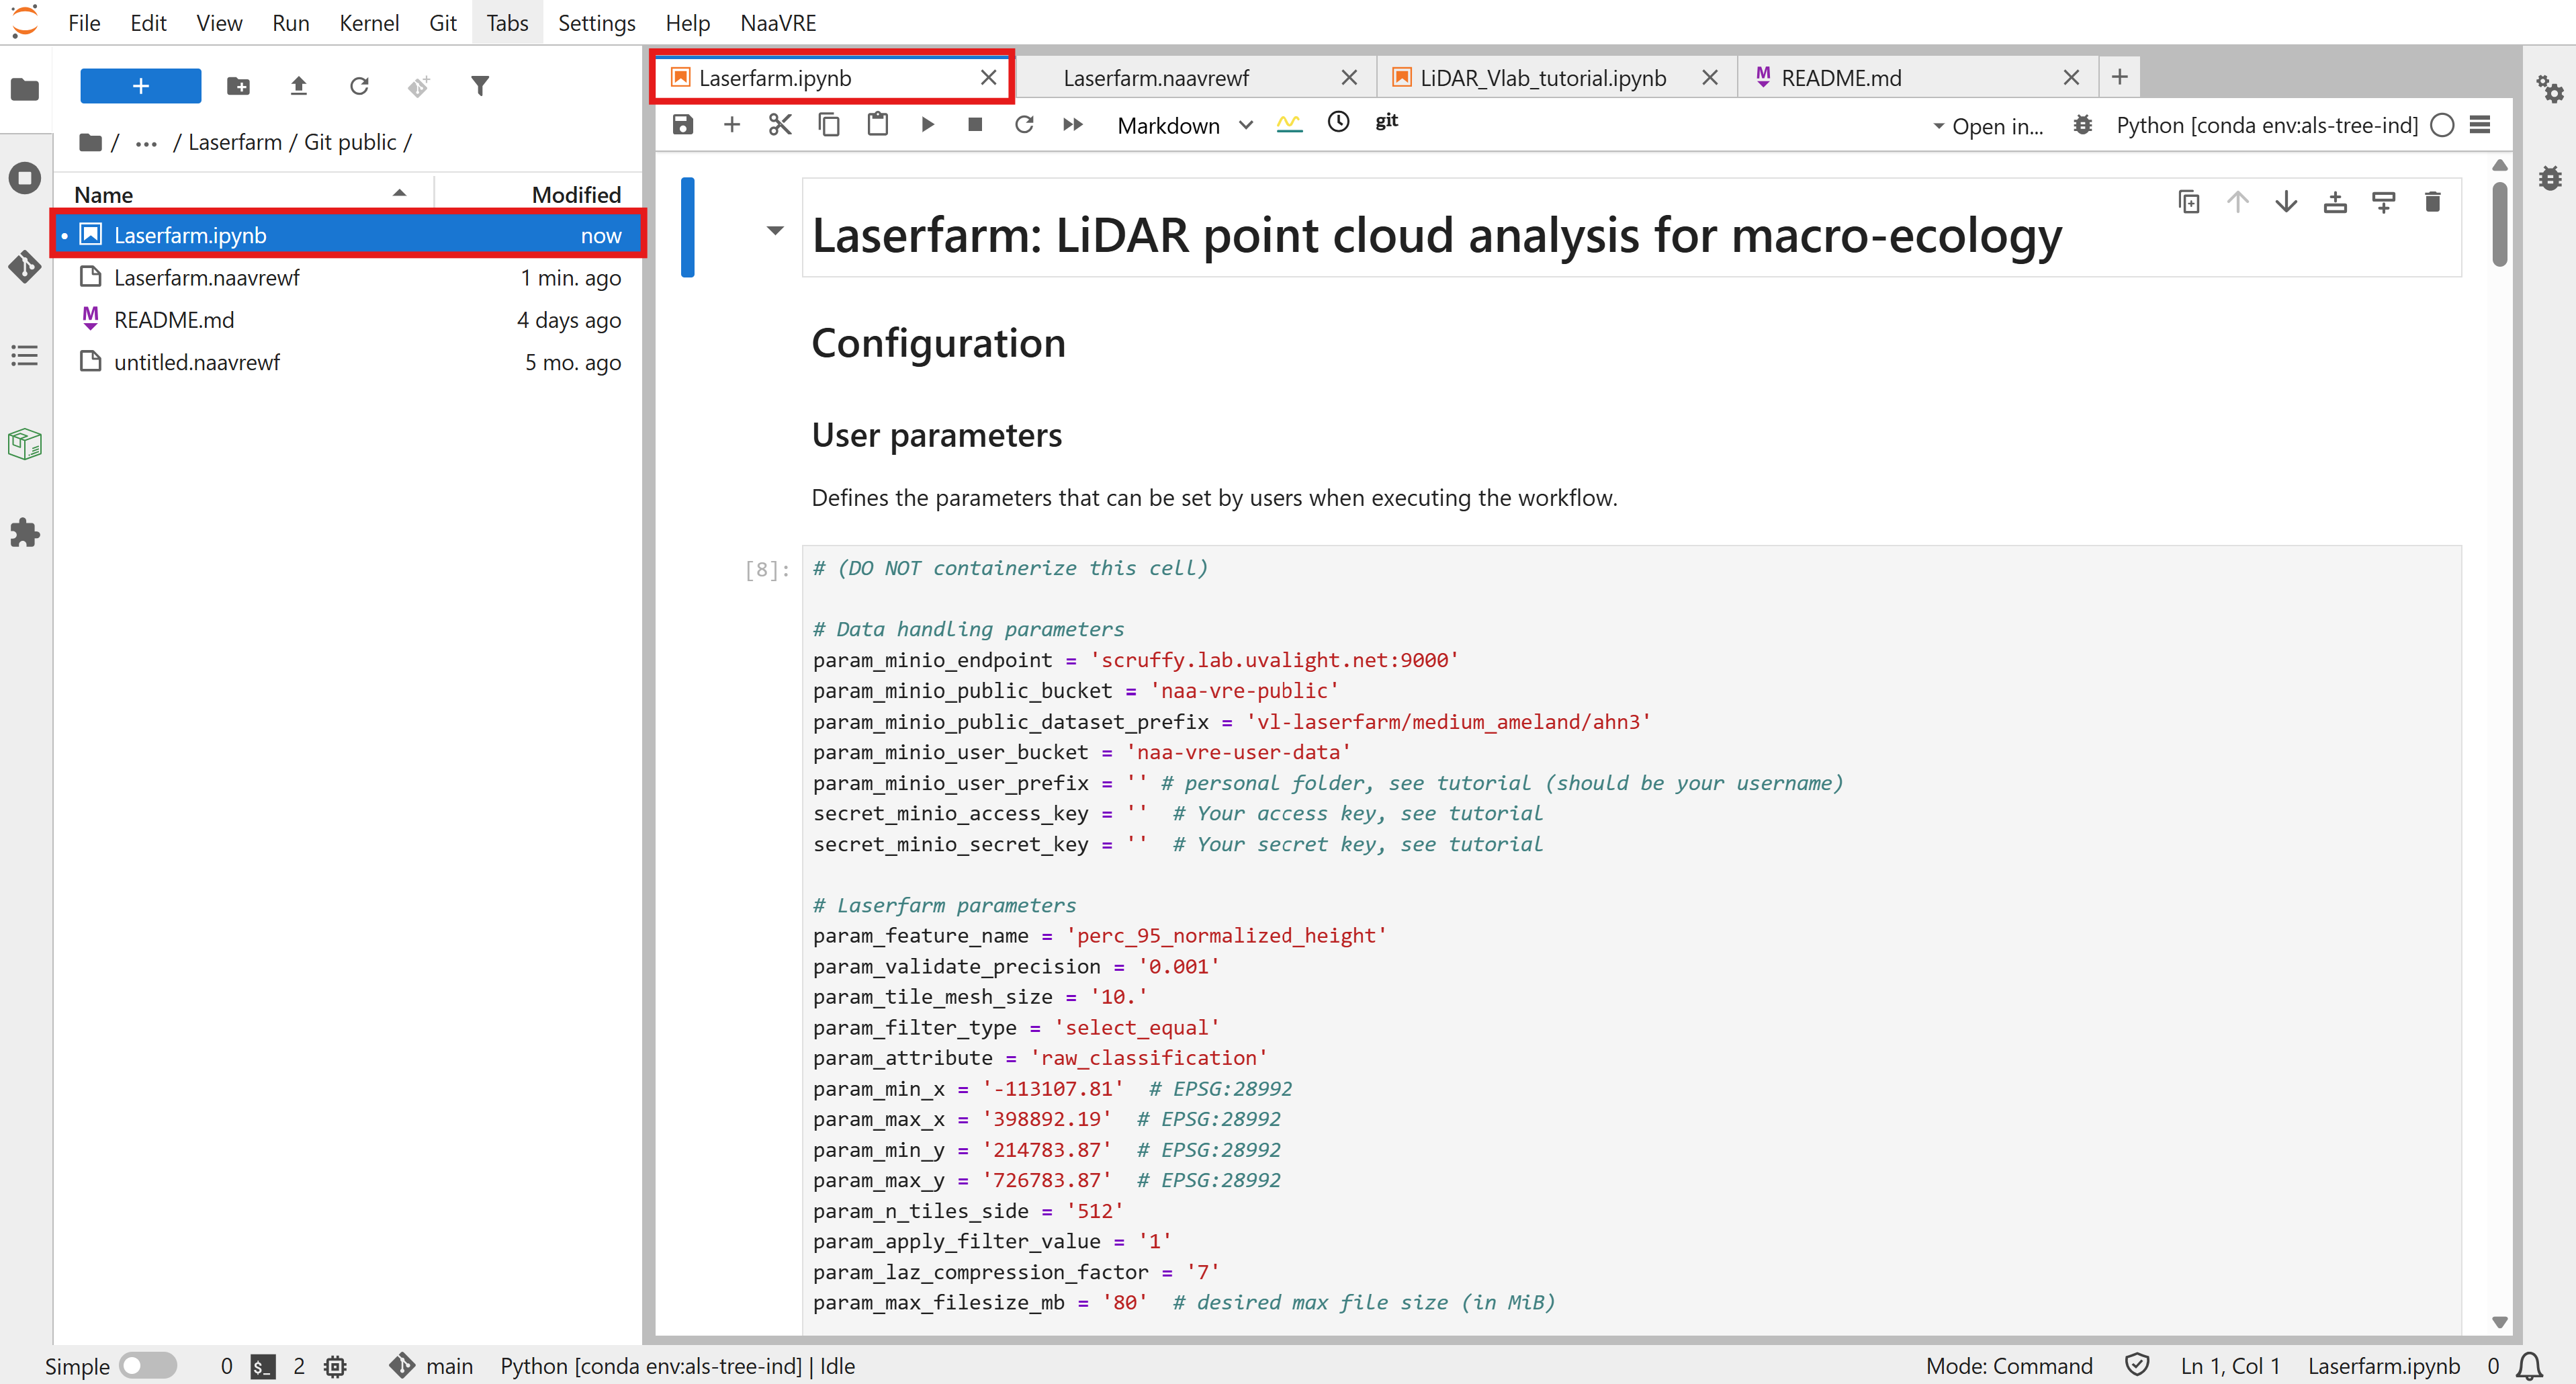

If you double-click the "[Laserfarm.naavrewf](https://github.com/NaaVRE/vl-laserfarm/blob/main/Laserfarm.naavrewf)" file (can be found in /Laserfarm/Git public/Laserfarm.naavrewf directory), you will open the Laserfarm NaaVRE workflow, which has already been containerized for you.


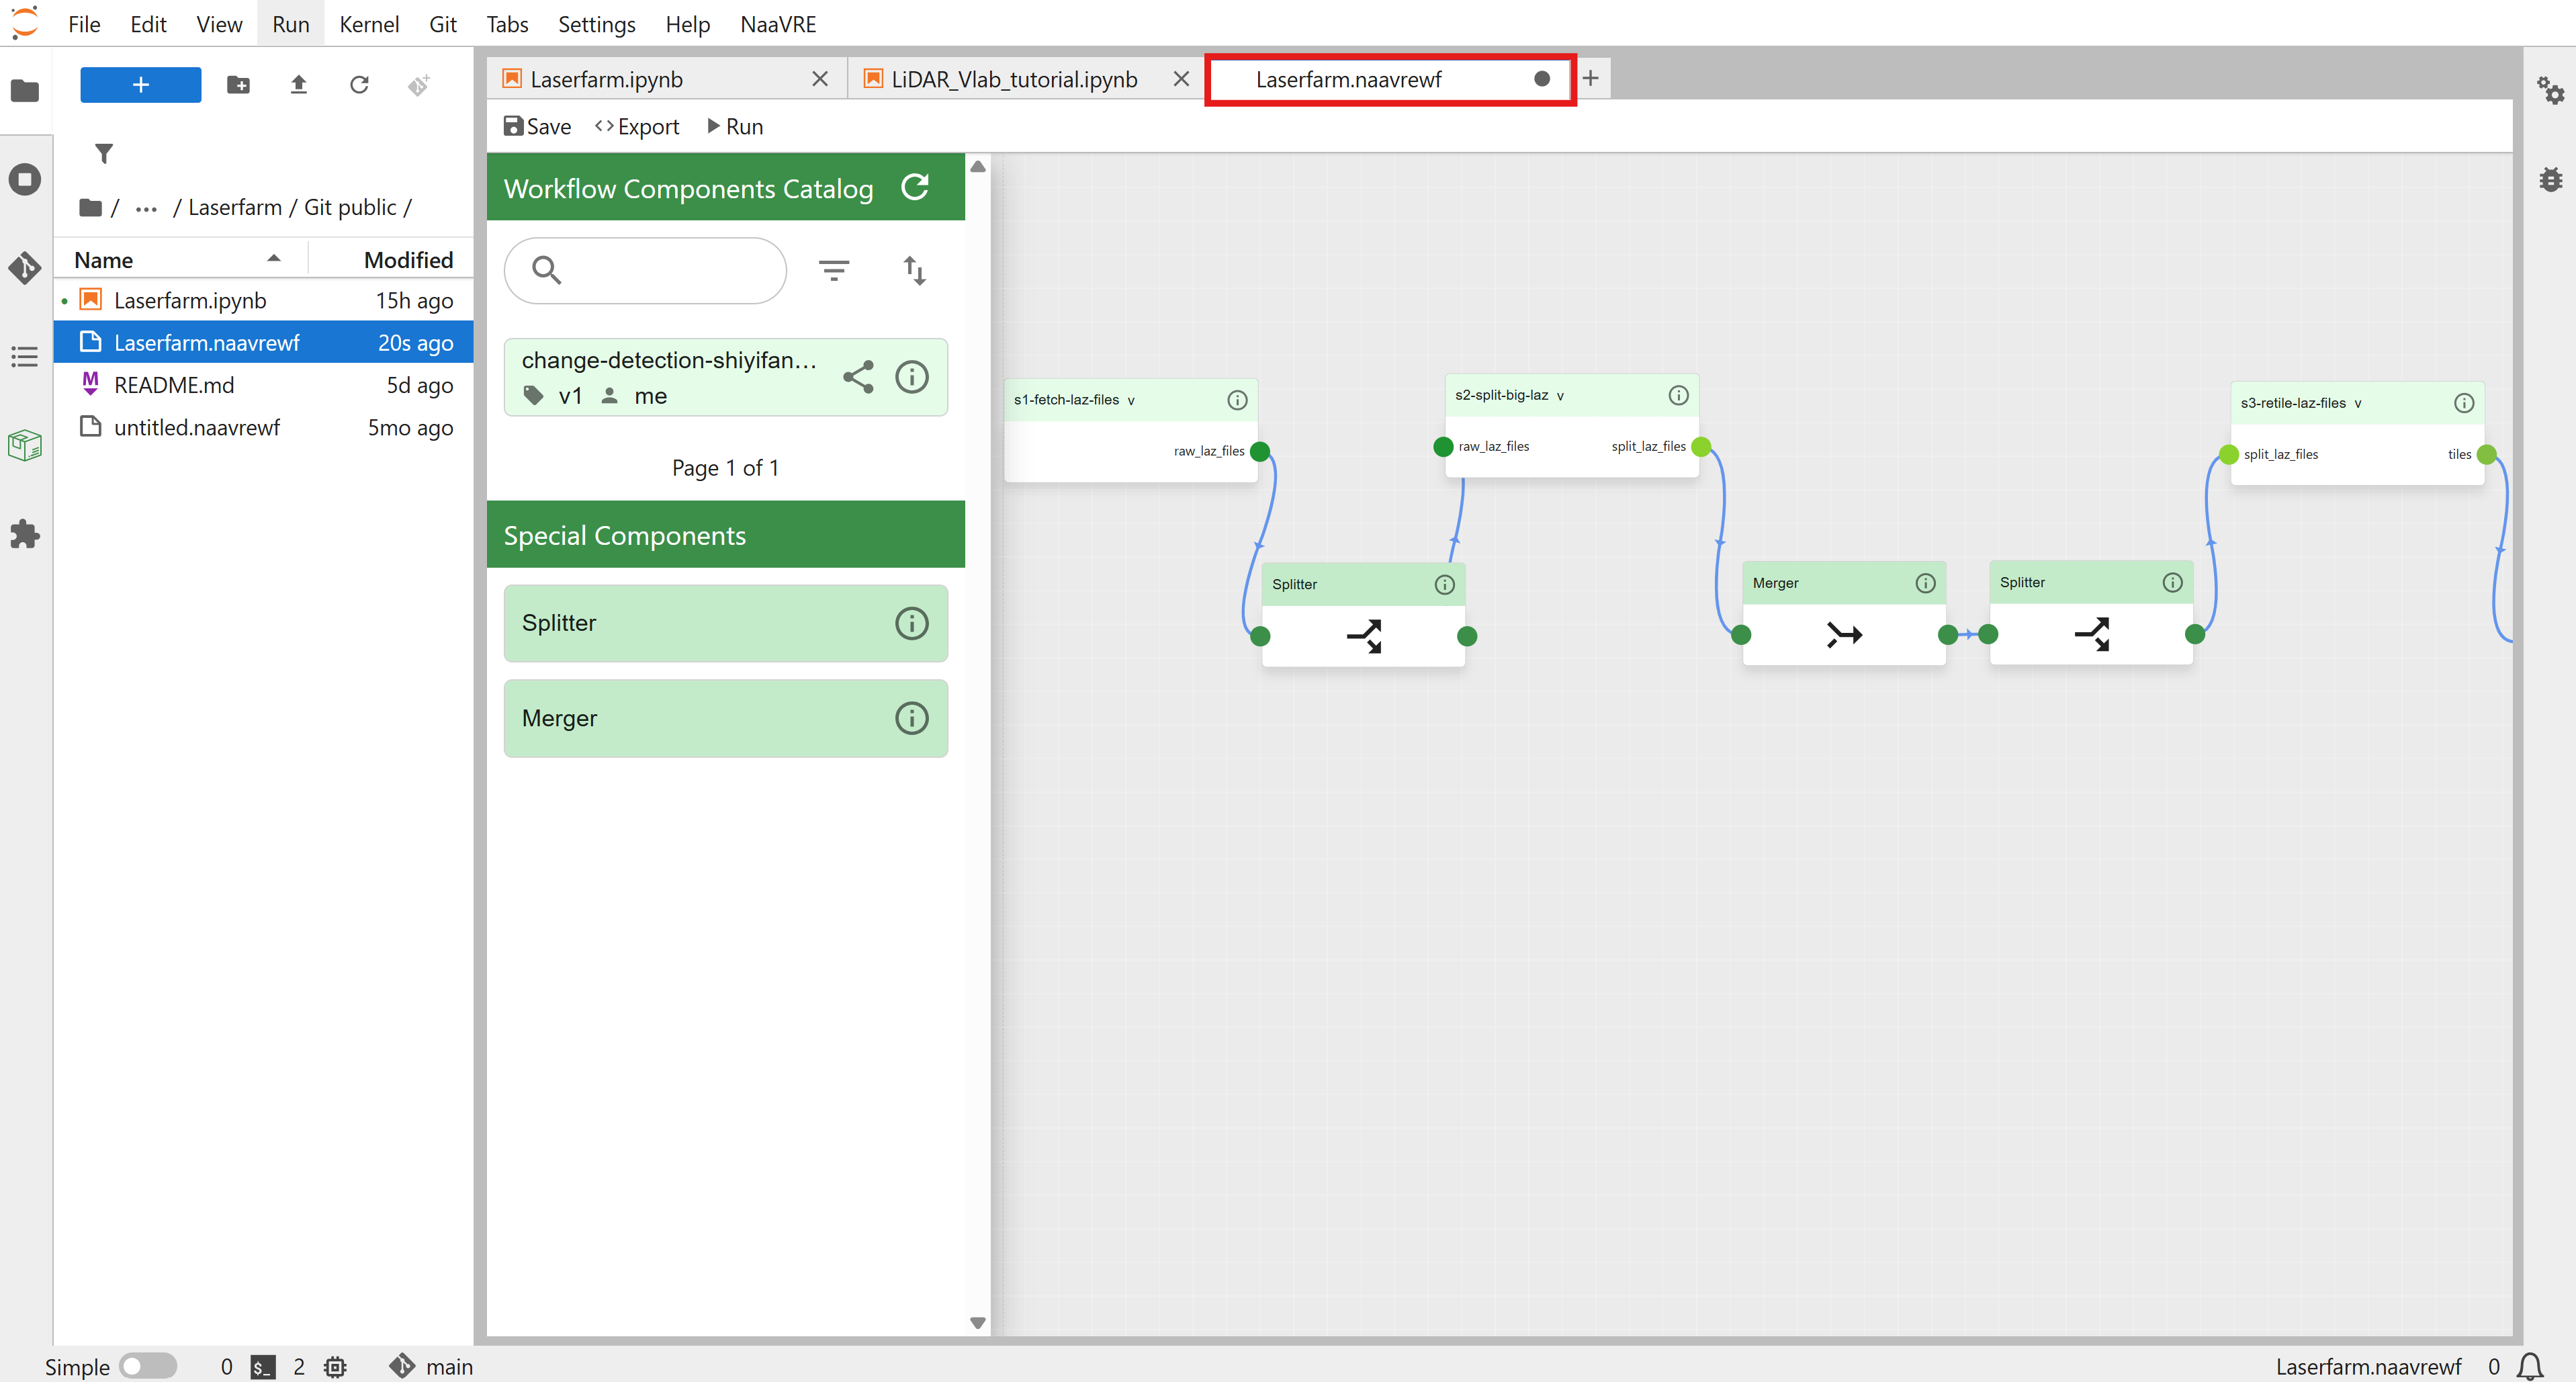

Each component within the NaaVRE workflow corresponds to the step (s1-s7) in the "Laserfarm.ipynb". That includes:

- **Step1: Fetch laz files**  (*Retrieve laz files from remote storage MiniO*)
- **Step2: Split big laz**  (*Split large laz files into smaller files*)
- **Step3: Retile laz files**  (*Split all files into tiles within the defined grid and numbers*)
- **Step4: Unique tiles**  (*Ensure that the list of tiles contains no duplicates*)
- **Step5: Extract features**  (*Extract defined LiDAR metrics based on normalized point cloud*)
- **Step6: Save GeoTIFF**  (*Rasterize extracted features into GeoTIFF files*)
- **Step7: Create figures**  (*Generate a PDF file to visualize the output raster*)

The source code for each step can be found at [vl-laserfarm/Laserfarm.ipynb](https://github.com/NaaVRE/vl-laserfarm/blob/main/Laserfarm.ipynb). Special cells (`splitter` and `merger`) are used to compose the workflow. You can find more detailed information about the NaaVRE experiment manager in the [documentation](https://naavre.net/docs/NaaVRE_documentation/experiment-manager/), where `splitter` and `merger` are explained.

> **`Splitter`**: This component is used to split an output array from a call into its elements and feed each element to the next cell. That way the next cell will be executed in parallel as many times as the number of elements in the array.
> 
> **`Merger`**: This component is used to merge the outputs of multiple cells into a single array.

For instance, in the integrated Laserfarm workflow, the `splitter` enables the retiled laz files being processed in parallel by different workers, while the `merger` merges extracted features from all files and allows the creation of one raster layer for each feature.

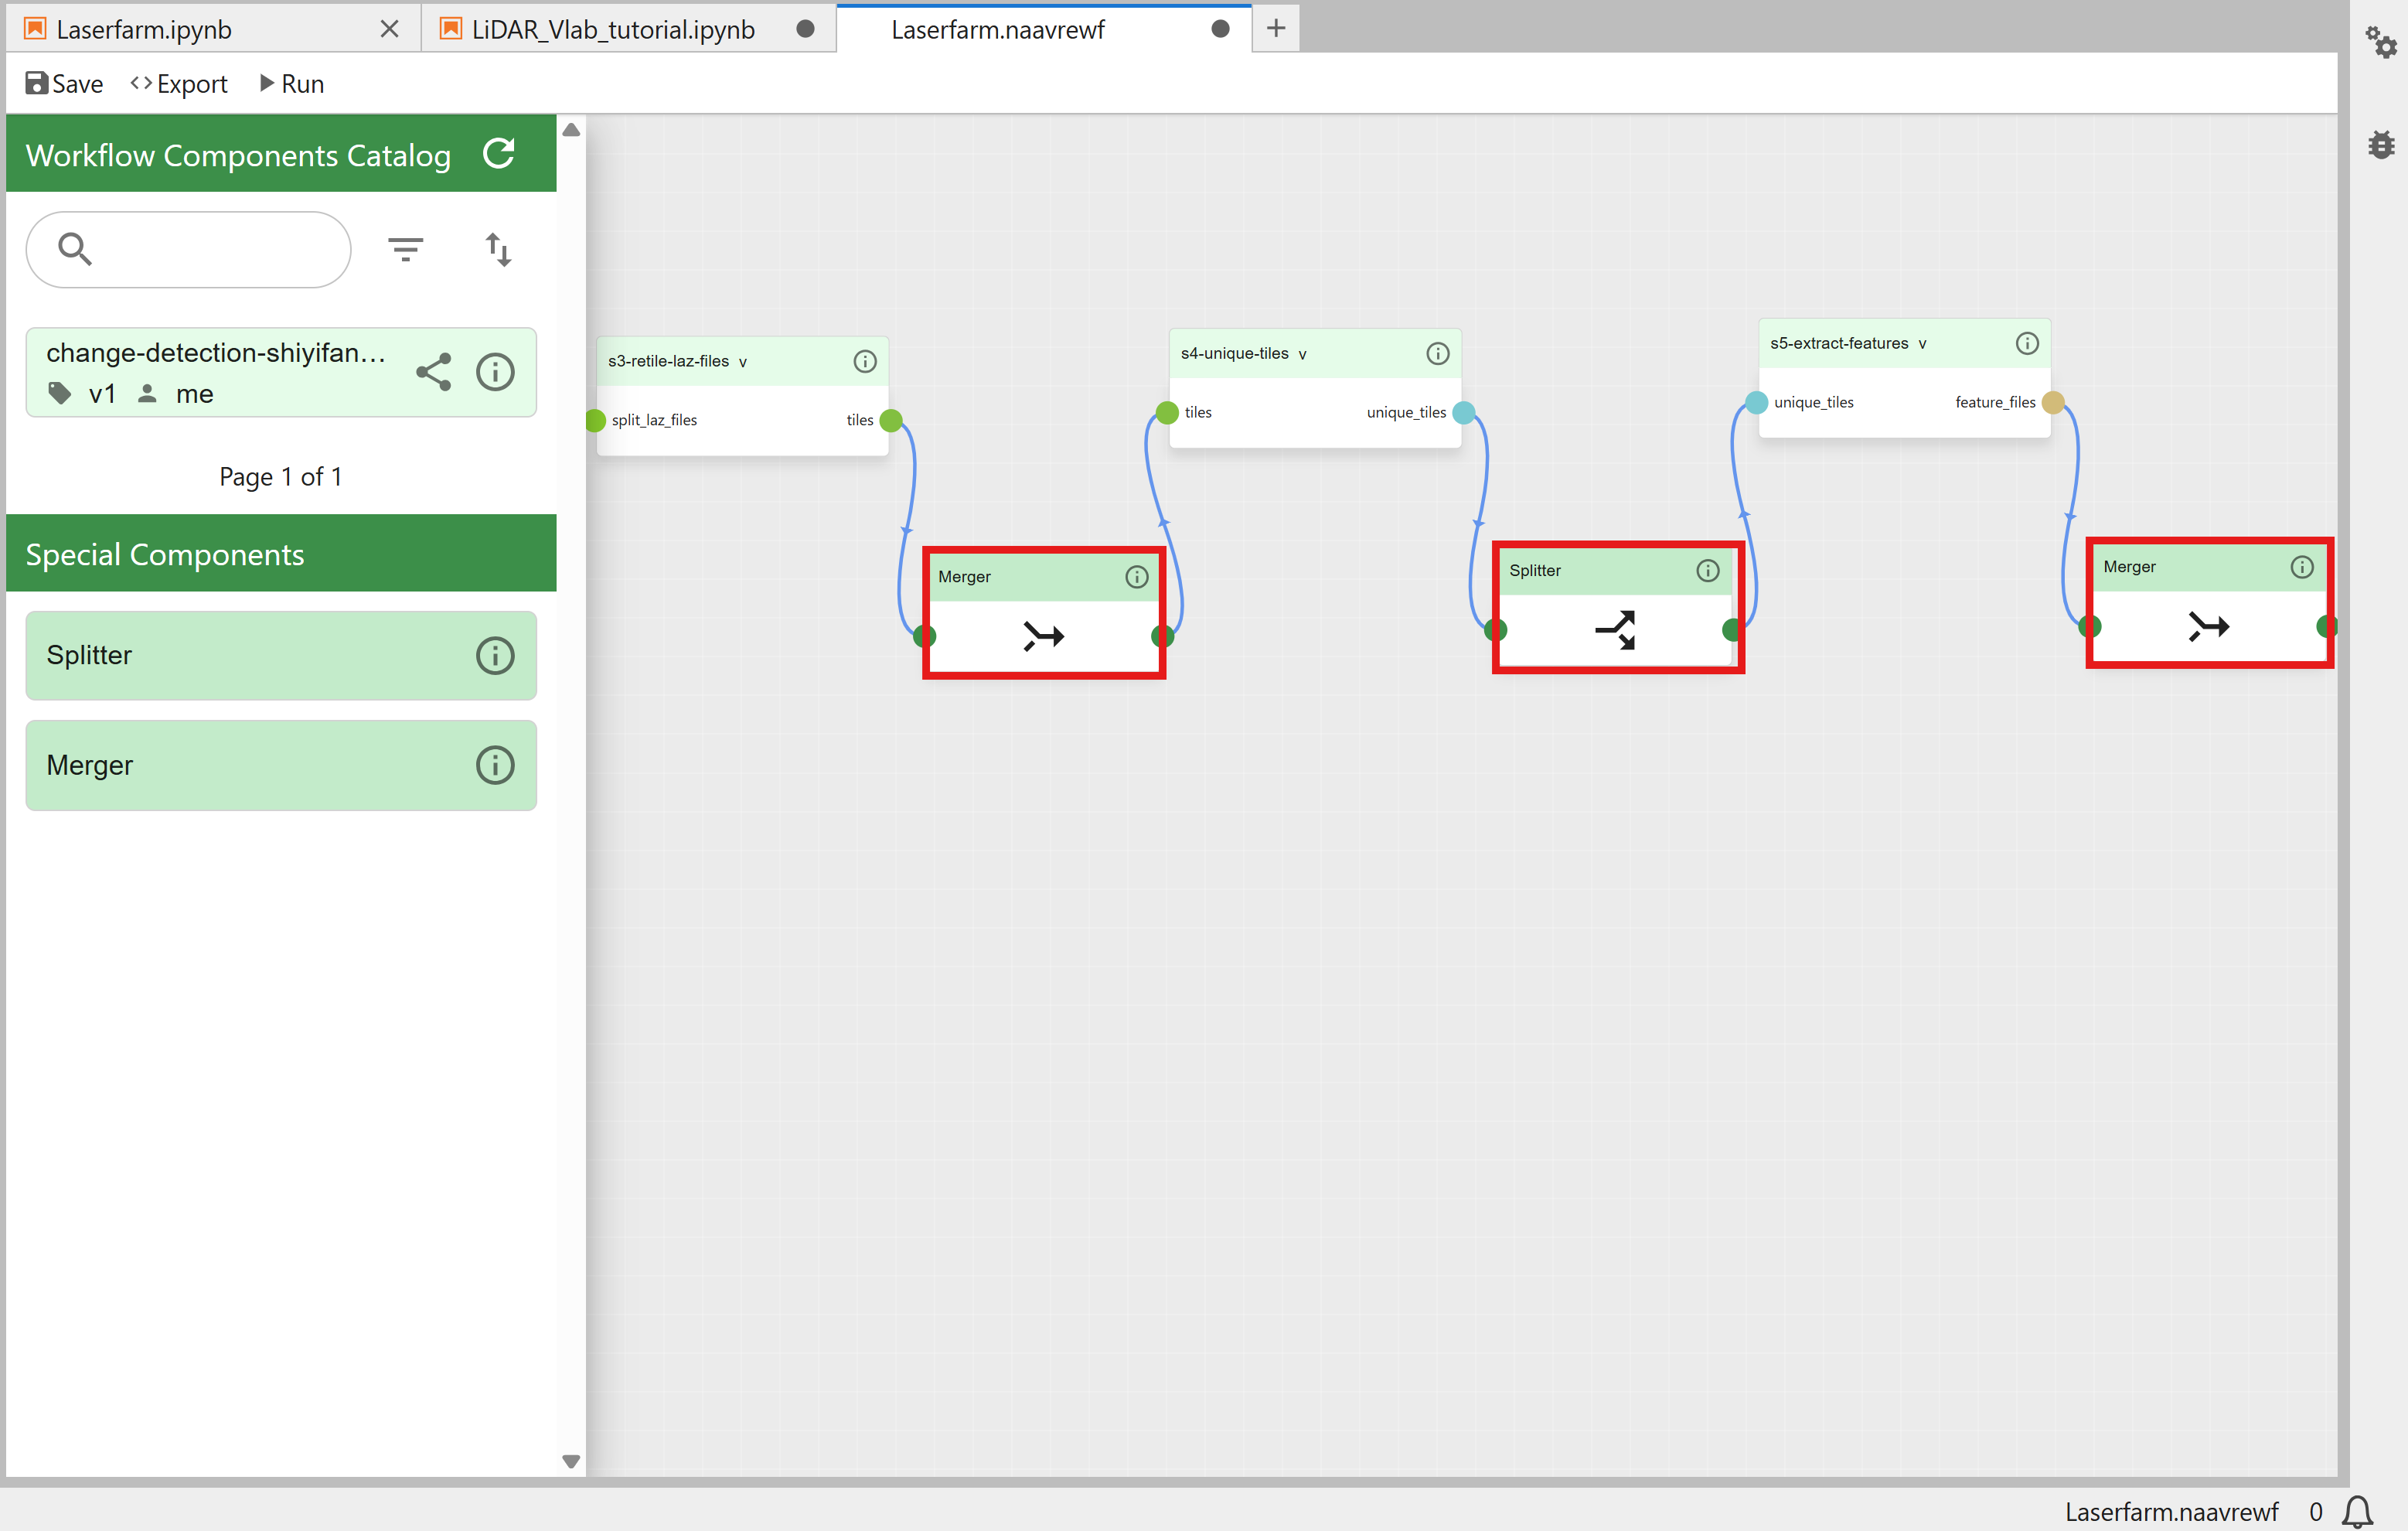

**Workflow execution**: We are now going to run the workflow to process point clouds from AHN datasets into GeoTIFF raster layers with extracted features. Find the `Run` button in the experiment manager and press it. An `execute workflow` pop-up should appear. Check all the parameters you can customize. Now click `Use default parameter values`. The majority of the parameters should be filled in.

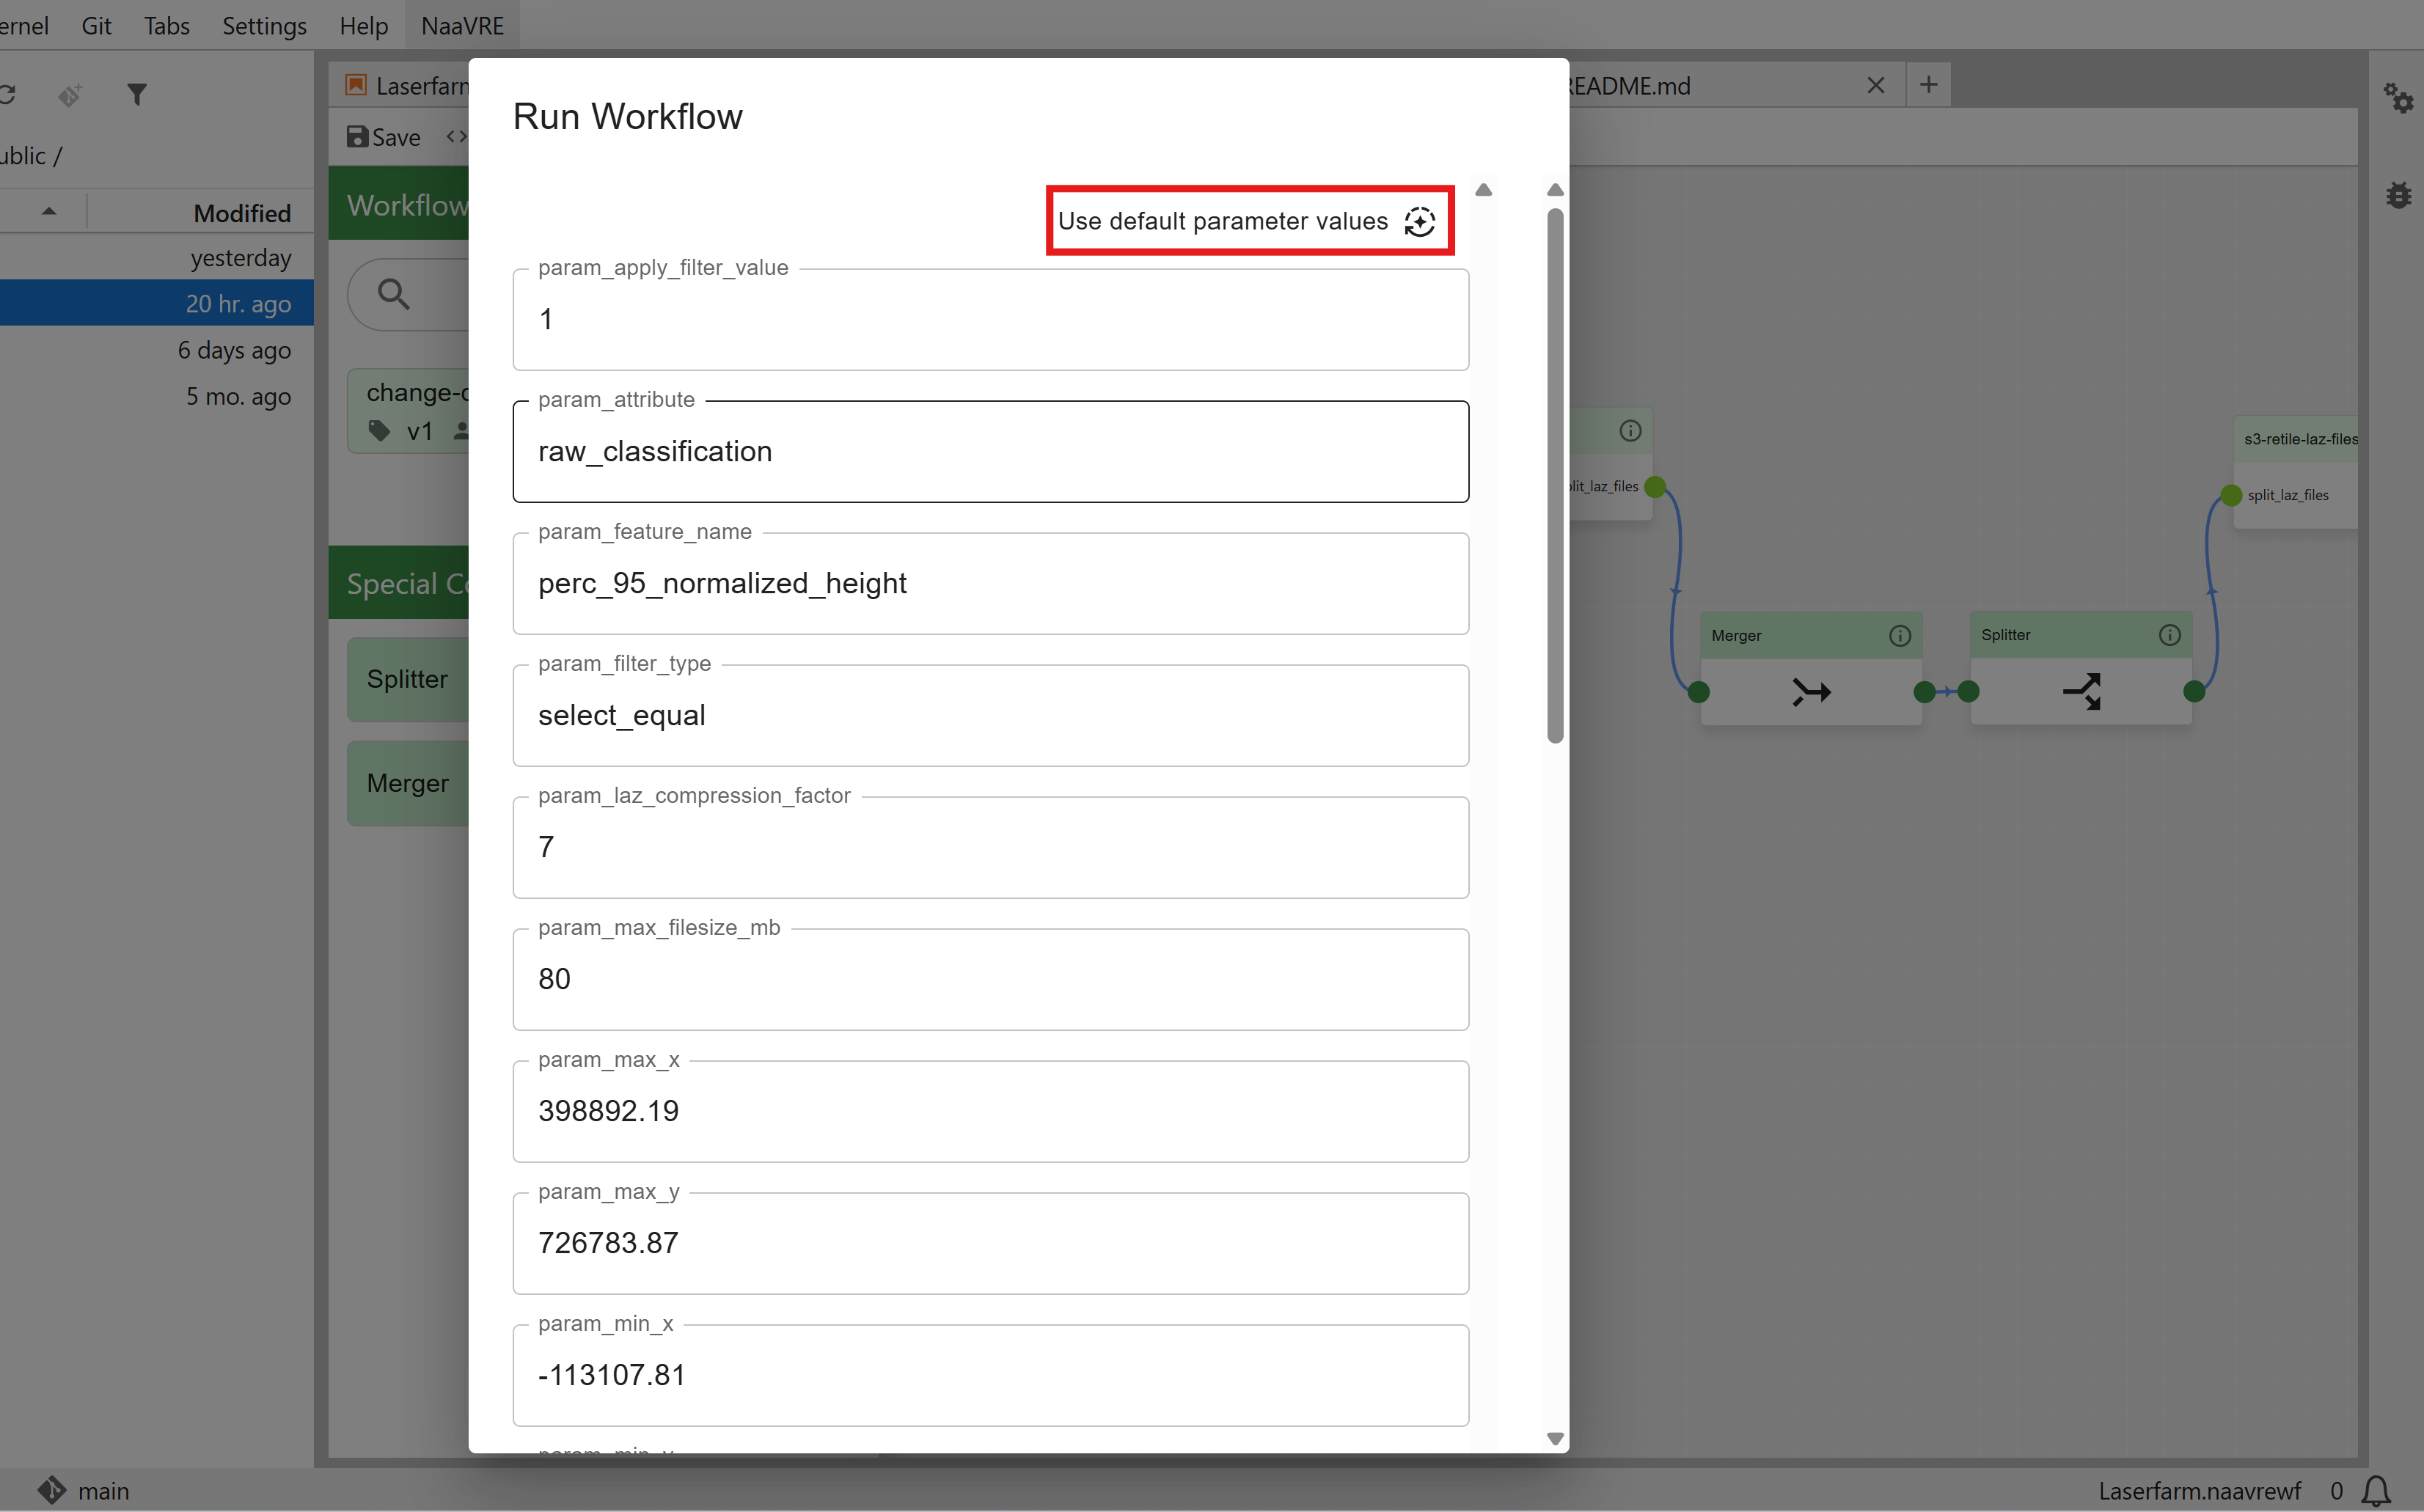

**Parameters that can be modified in the workflow** (following the order in the workflow excution pop-up window)

`param_apply_filter_value = '1'`

* _apply_filter_value_ selects the points with a specific attribute value. Here, 1 means classification code 1, representing vegetation points in the point cloud.


`param_attribute = 'raw_classification'`

* _attribute_ defines what attribute of each point you want to select for further calculation. Here, _raw_classification_ refers to the classification attribute assigned to each point.


`param_feature_name = 'perc_95_normalized_height' `

* _feature_name_ defines the feature(s) you want to calculate, see https://laserchicken.readthedocs.io/en/latest/#features for all the features you can calculate using the Laserfarm workflow.

`param_filter_type= 'select_equal'`


* _filter_type_ selects the points you want to consider in the calculation based on the defined _attribute_, _filter value_ and _filter type_. Here, we select points with a classification value (_attribute_) equal to (_filter_type_) 1 (_filter value_), which are vegetation points.  

`param_laz_compression_factor = '7'`

`param_max_filesize_mb = '80'  # desired max file size (in MiB)`


* _laz_compression_factor_ and _max_filesize_mb_ only use for large files that need to be split into smaller files for computational efficiency (demanded memory, etc).




``param_min_x = '-113107.81'``

``param_max_x = '398892.19'``

``param_min_y = '214783.87'``

``param_max_y = '726783.87'``

``param_n_tiles_side = '512'``


* The coordinates are pre-defined for the Netherlands. The grid covers the area of the Dutch National AHN point cloud data. If you want to process LiDAR data from other countries, you need to adjust the grid to fit the input data.

`param_minio_endpoint = scruffy.lab.uvalight.net:9000`

`param_minio_public_bucket = naa-vre-public`

`param_minio_public_dataset_prefix = vl-laserfarm/Workshop/AHN4/`

* Those are the directories for your input data, where you can modify to the folder of your test data.  

`param_minio_user_bucket = naa-vre-user-data`

`param_minio_user_prefix = [the e-mail address you used to log into NaaVRE]`

* Theose are the directories for your output data, where you only need to fill in your login email adress as _user_prefix_. This is also the folder you can find the output files after excuting your workflow. 

`param_tile_mesh_size = '10.'`

* _tile_mesh_size_ defines the spatial resolution for your final raster output (GeoTIFF layers)

`param_validate_precision = '0.001'`

* _validate_precision_ is set to avoid points falling on the edge of the tiles, you can keep as it is.

`secret_minio_access_key = [your MinIO Access key (See "MinIO storage")]`

`secret_minio_secret_key = [your MinIO Secret key (See "MinIO storage")]`

* Those secret keys are your credentials for the MinIO console (https://scruffy.lab.uvalight.net:9001/login). You can generate them following the instructions [here](https://docs.google.com/presentation/d/112Vs-vsOonVq1TlC4WprzWR6s9XntOBGgoFGbbT_FDg/edit).

Now, you can press `run` and submit your workflow. 

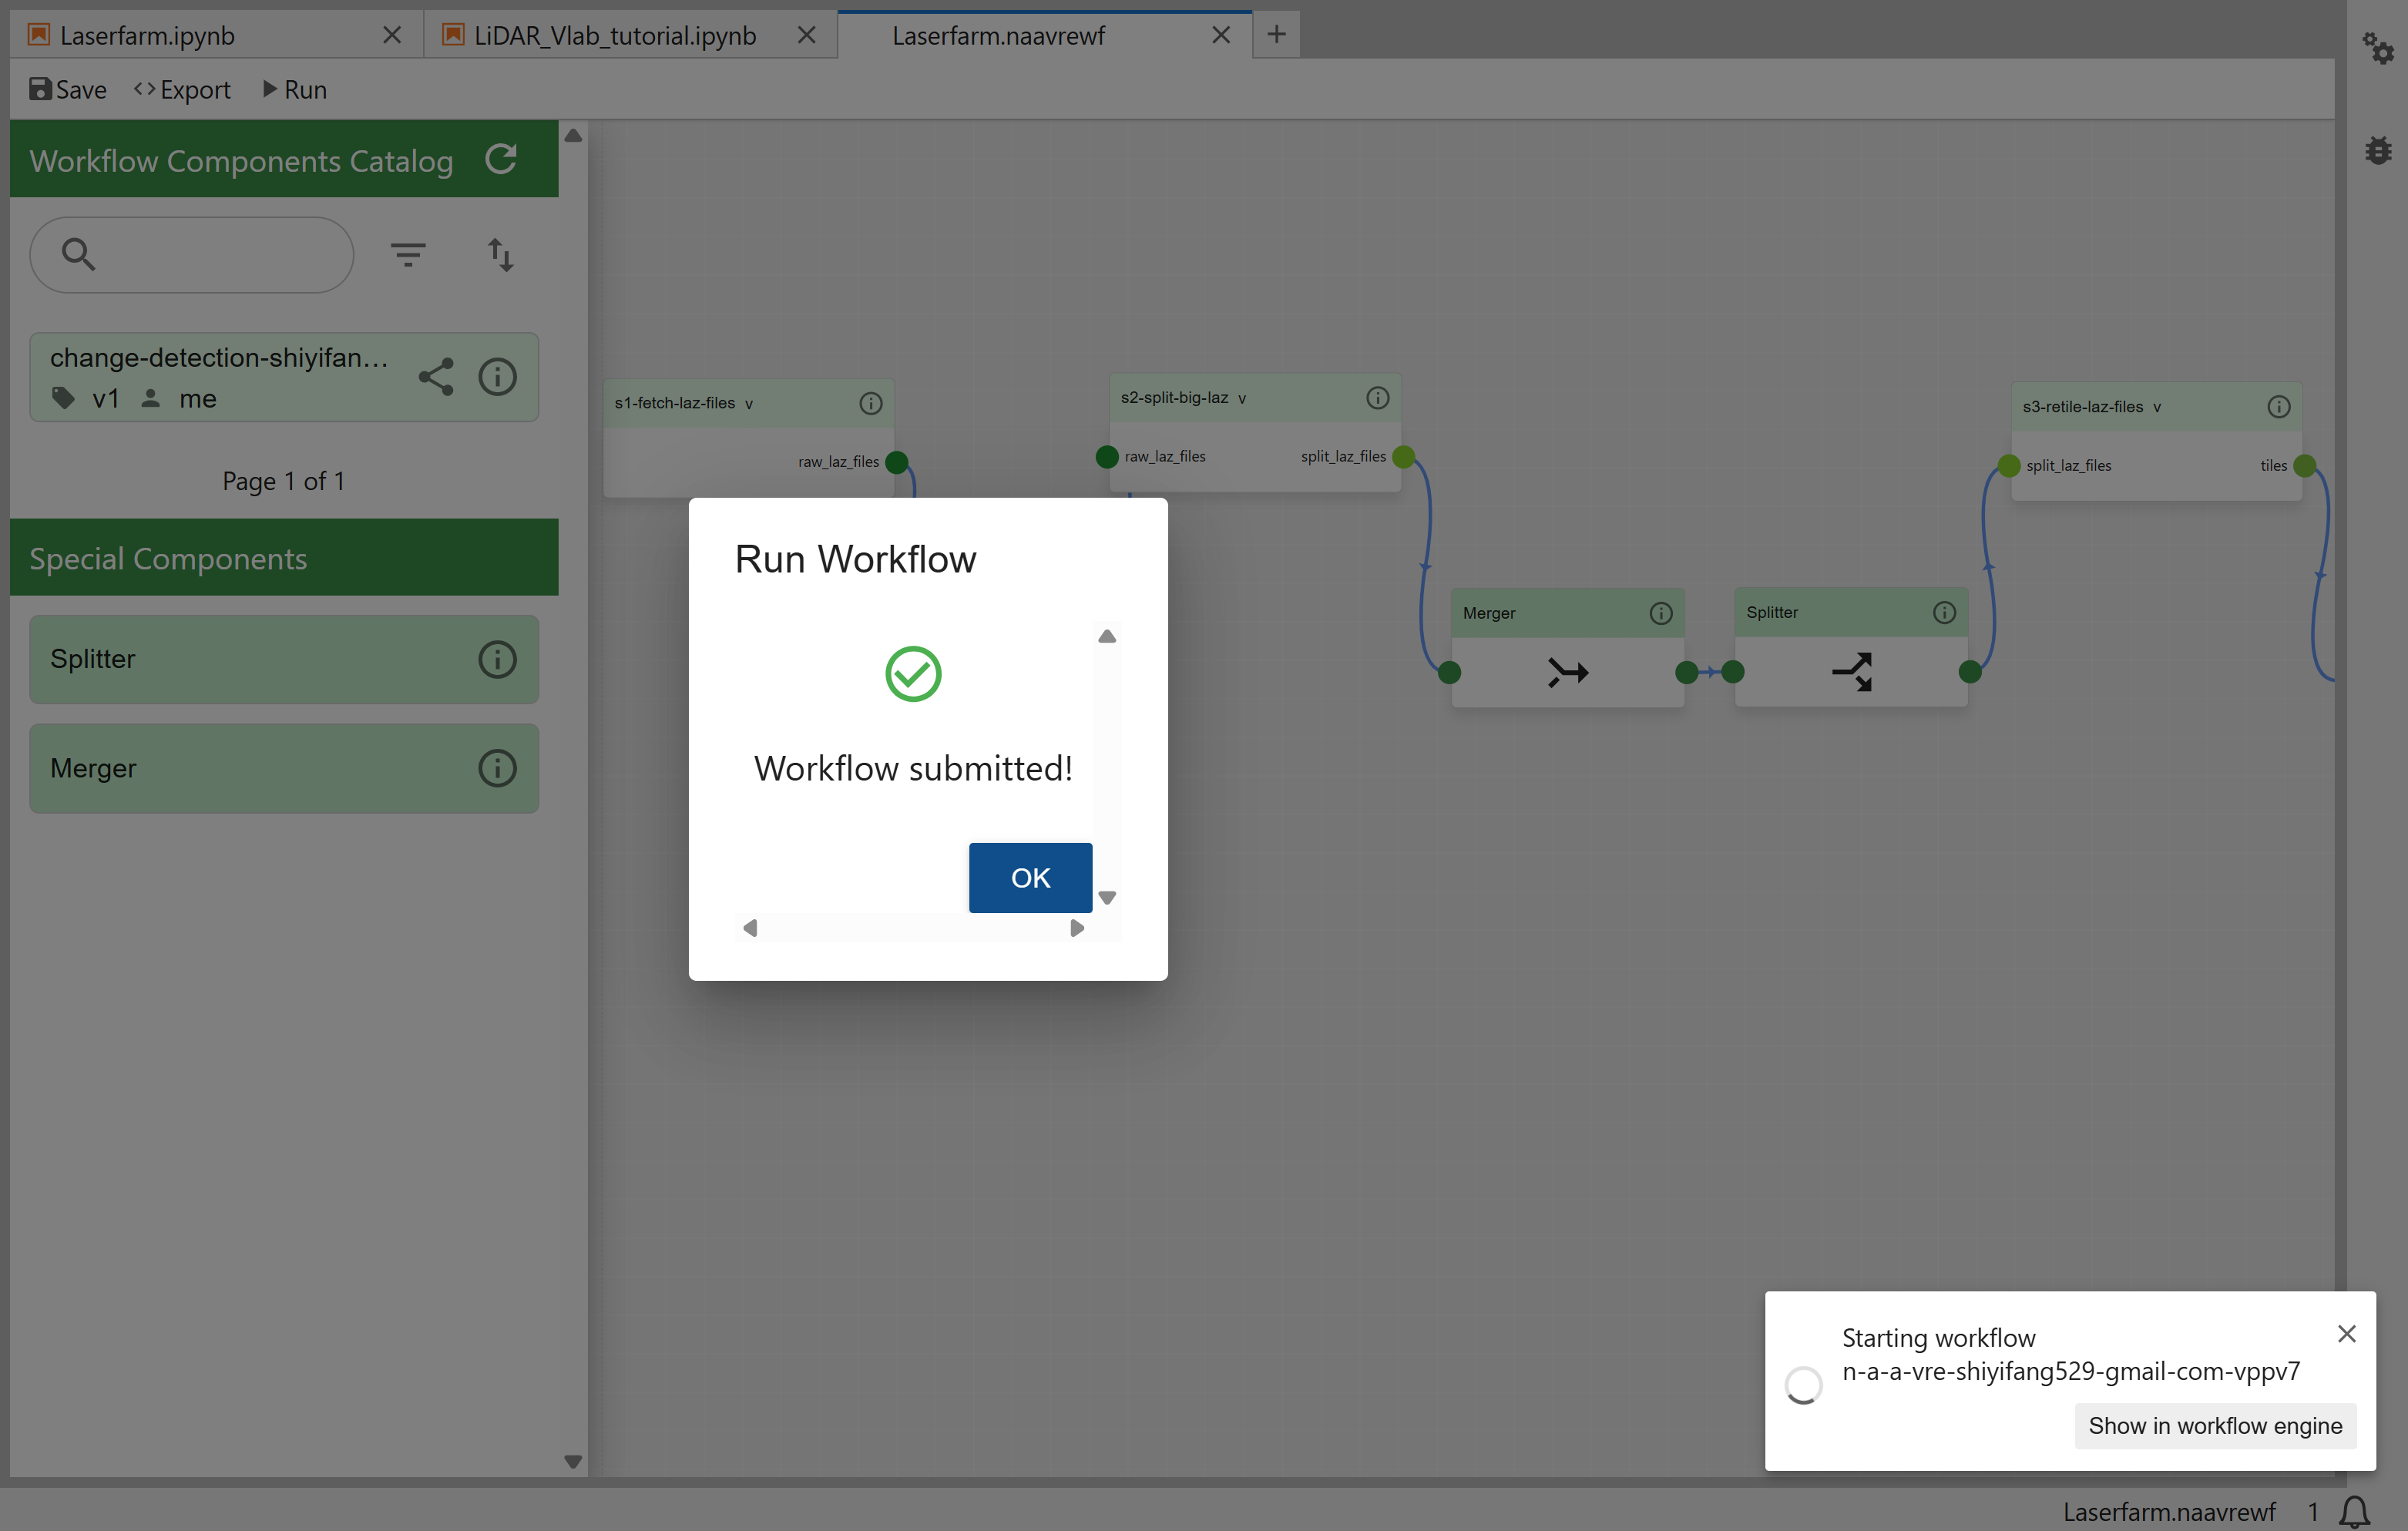

You can check your submitted workflow by clicking `Show in workflow engine` at the bottom right window. Then you will be directed to the Argo workflow interface. If required, log in with the option "If your organisation has configured single sign-on:"

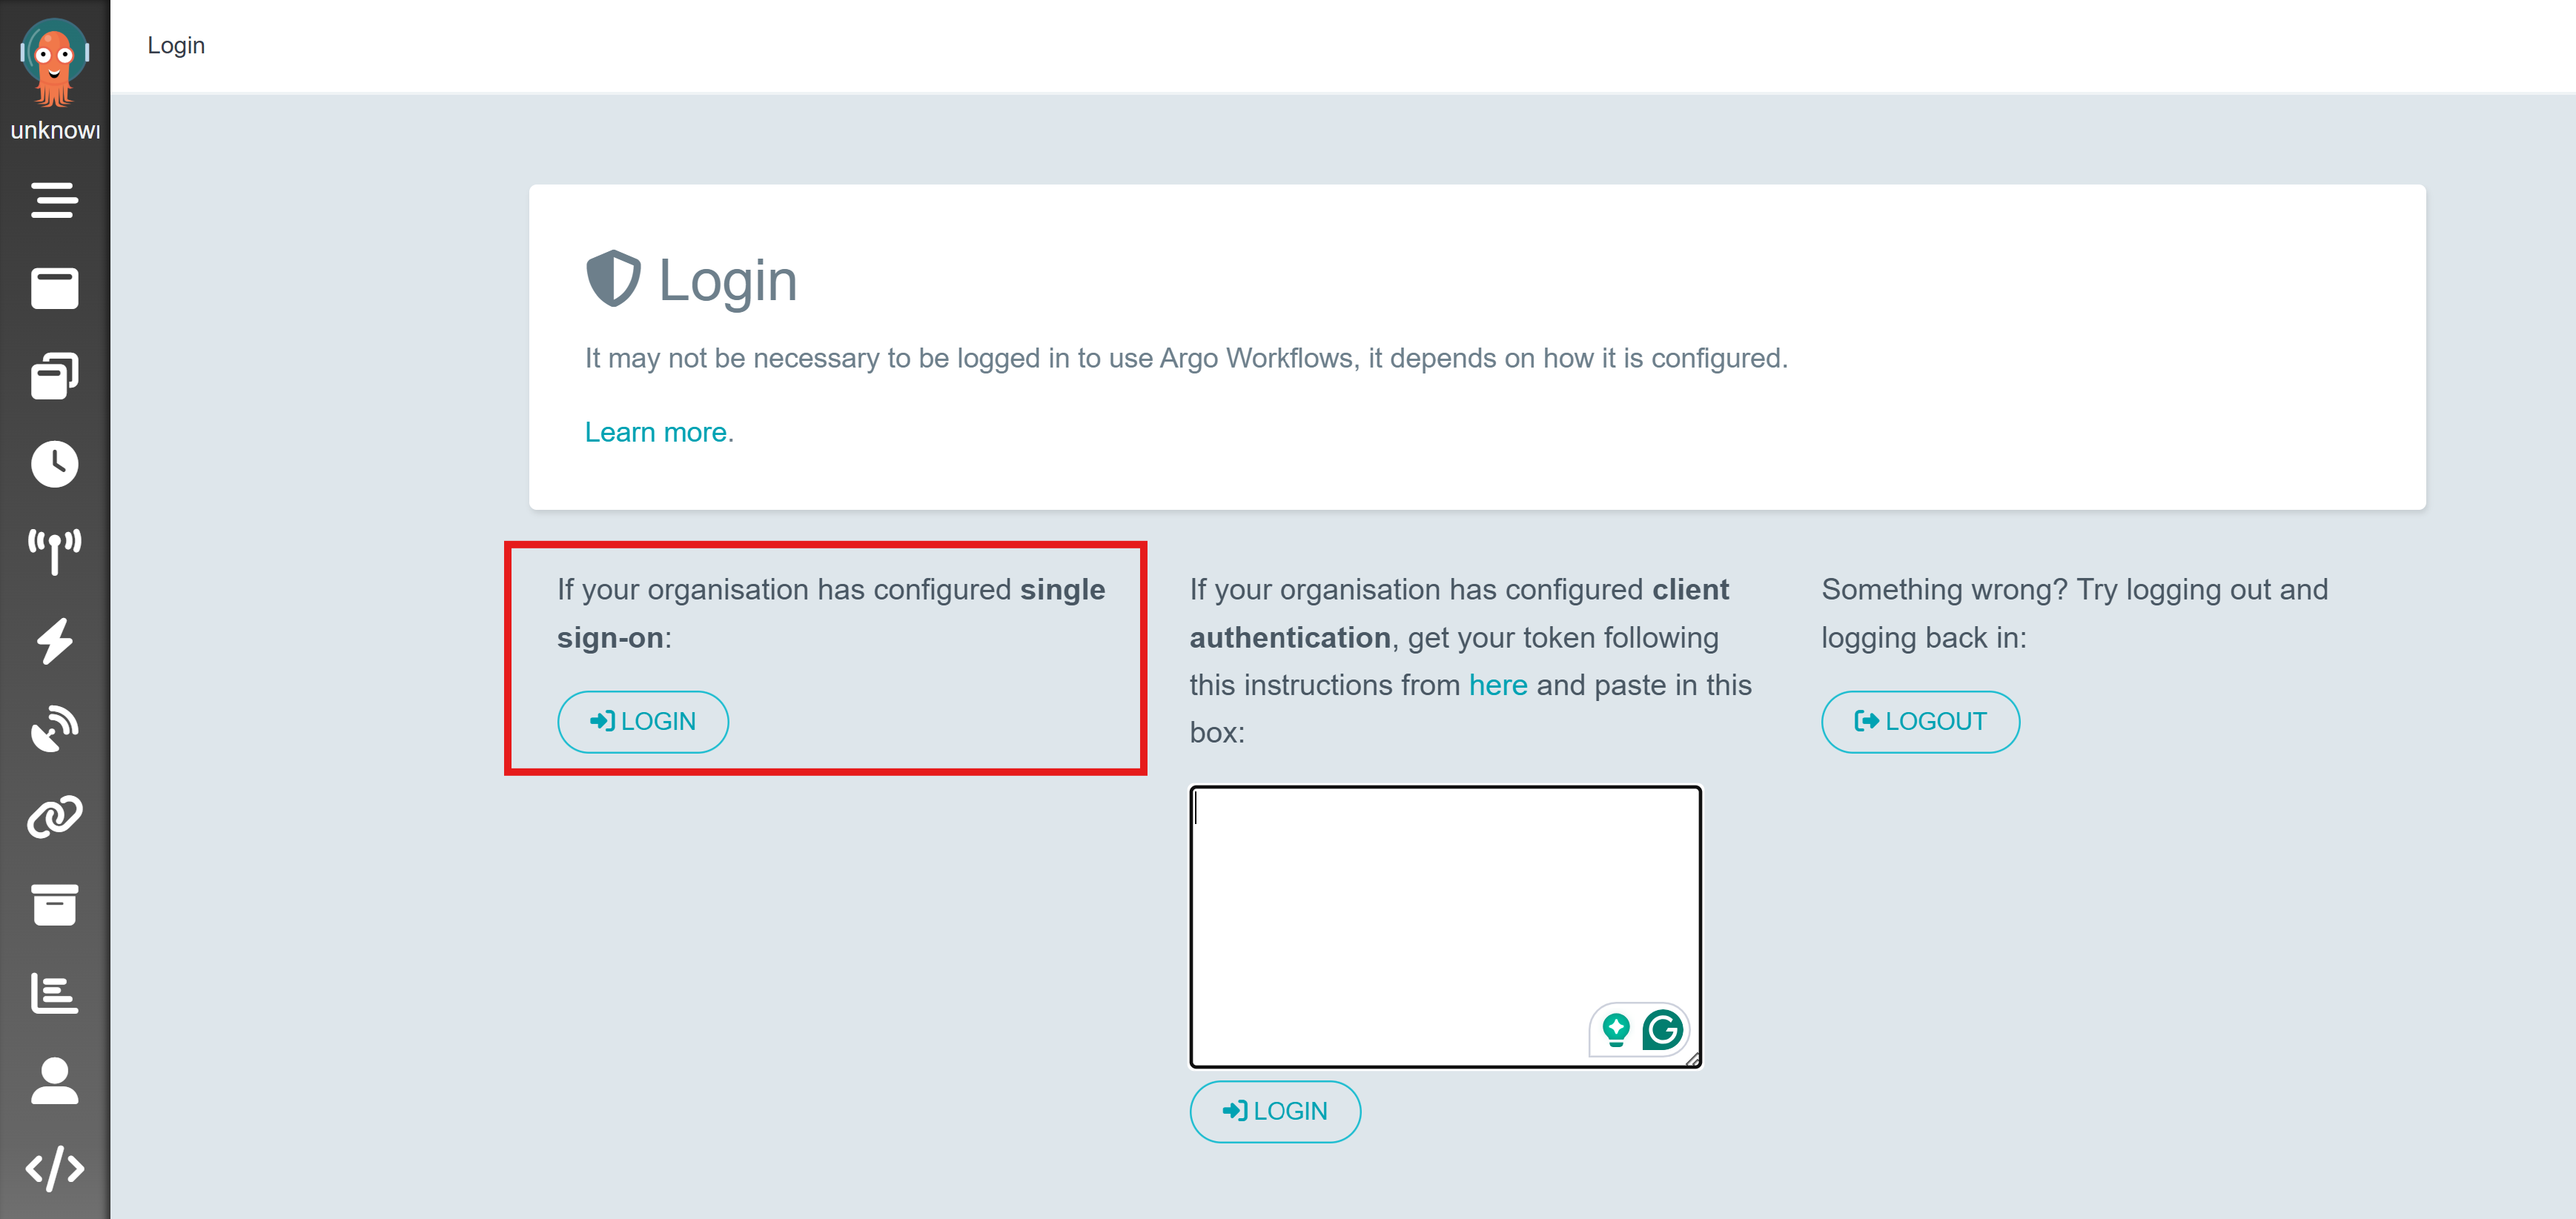

You should see a page that shows the progress of your workflow execution similar to this: (if nessesary, look for a workflow that has your username and has started recently and open it).

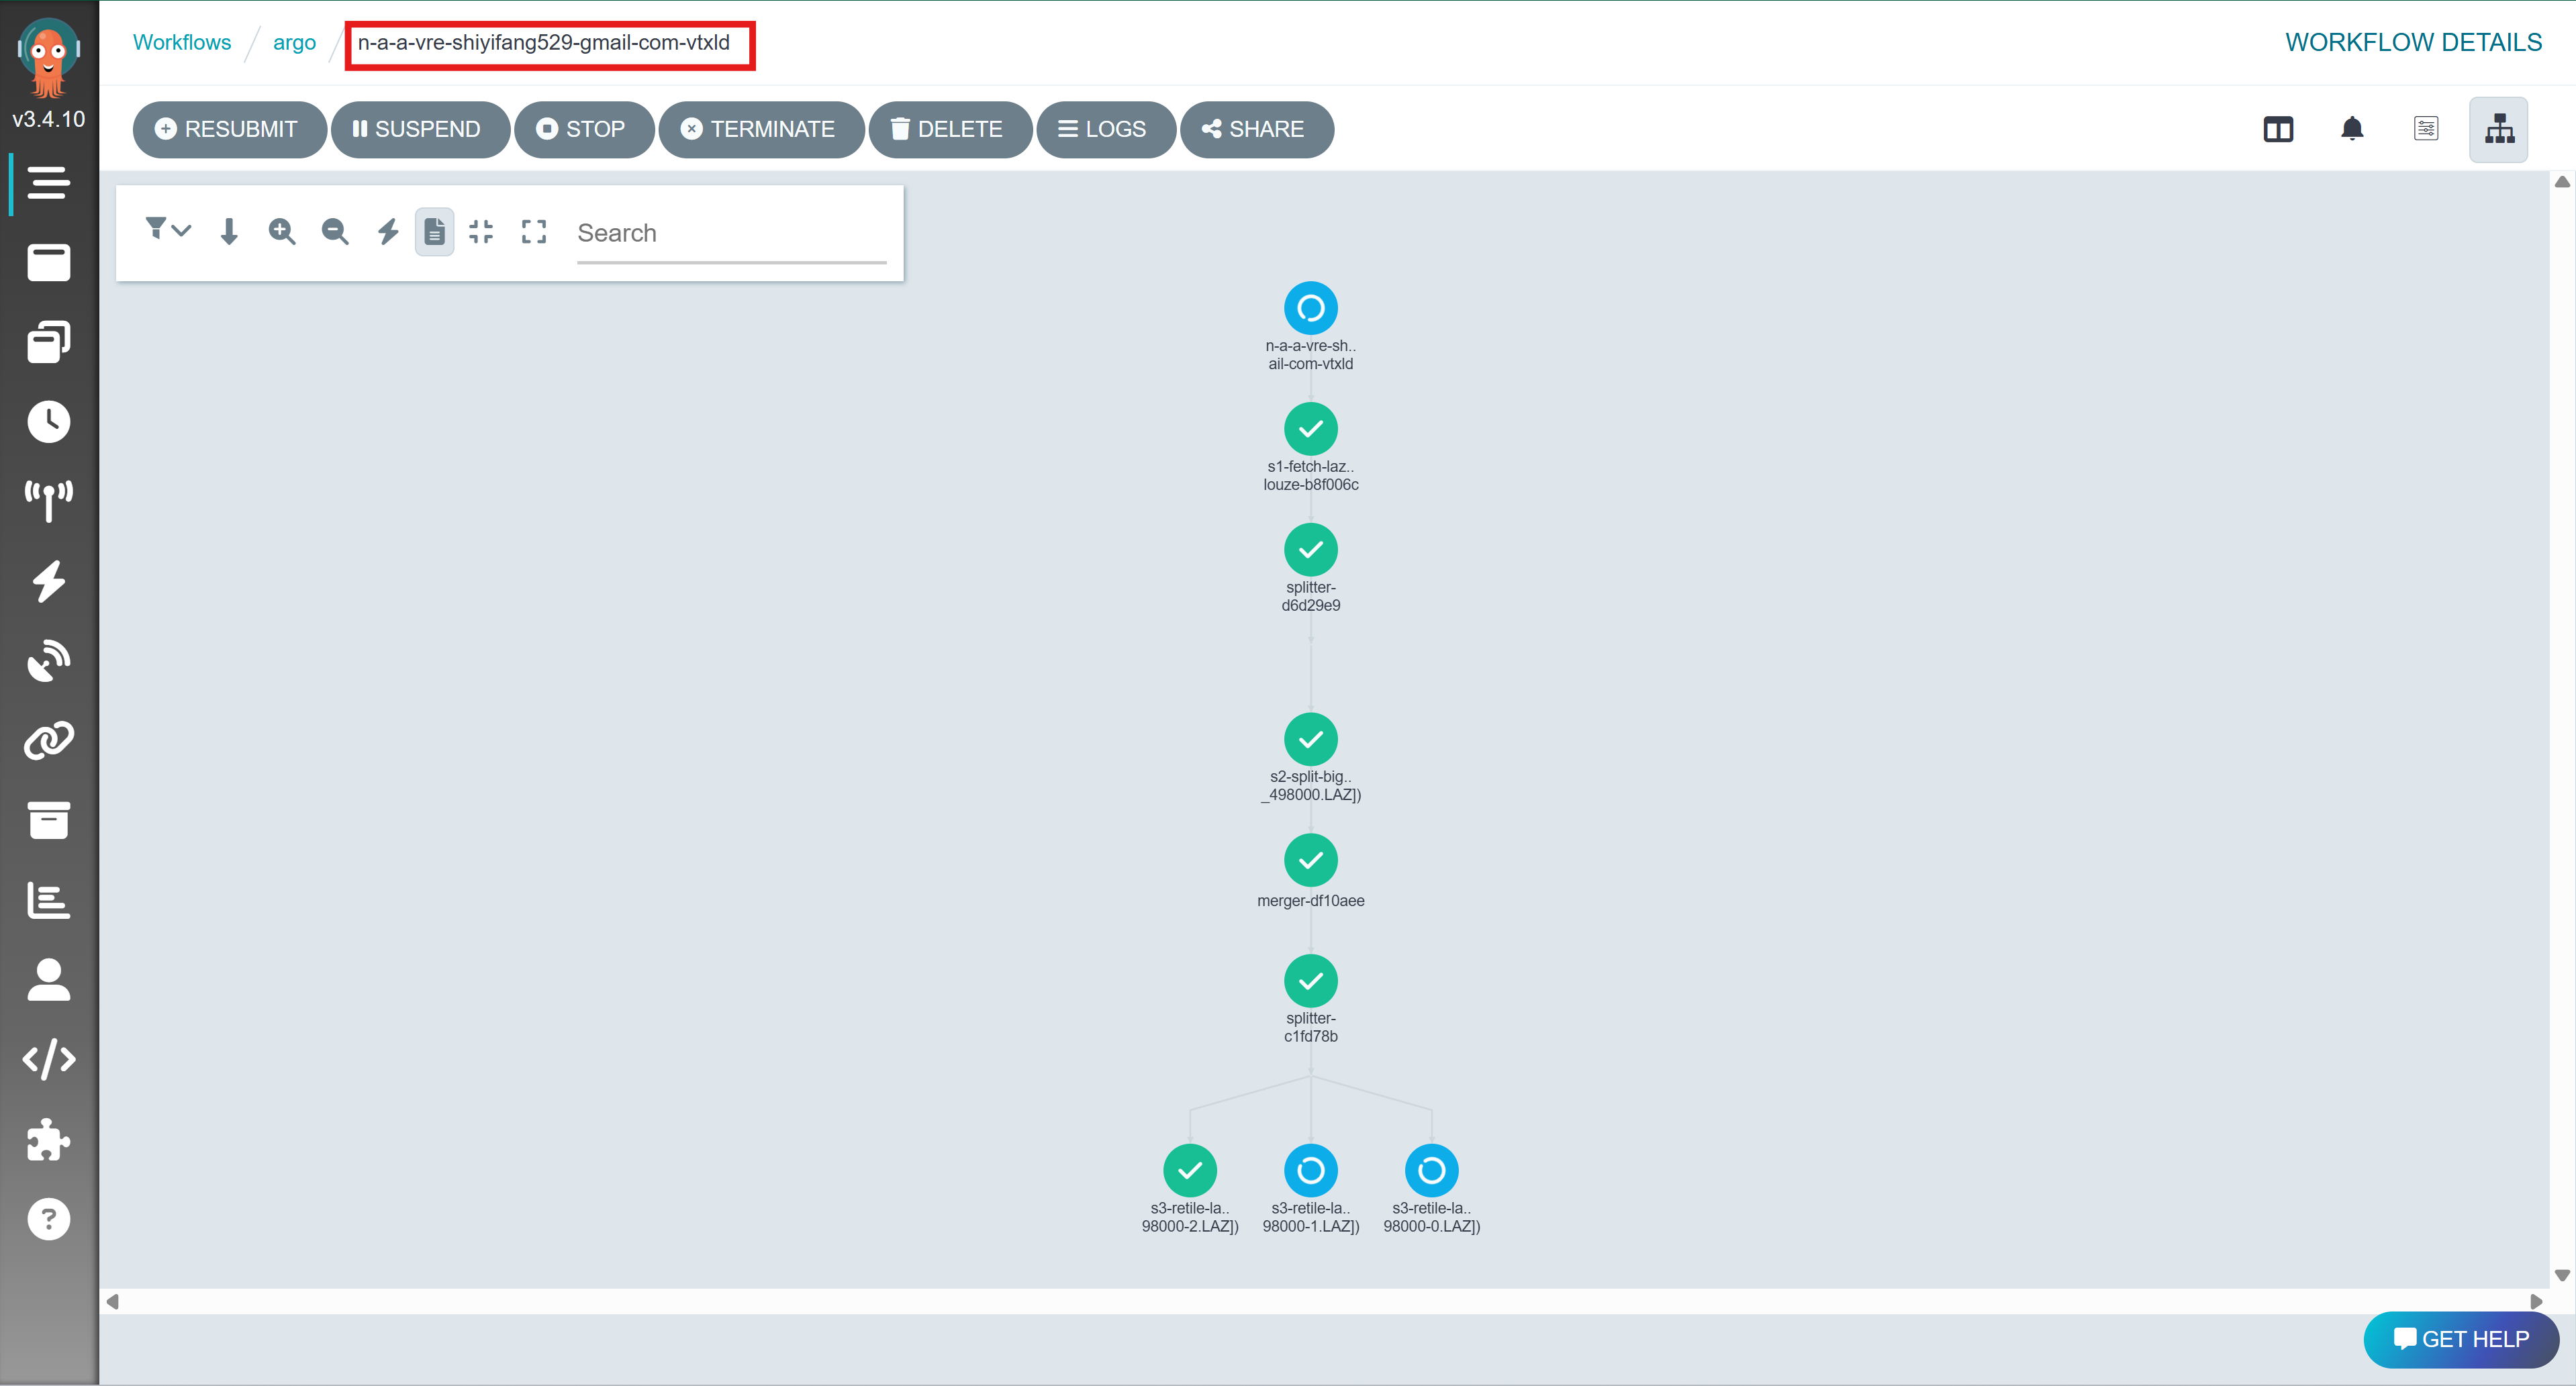

**Workflow success**: Once the workflow completes successfully, you can see all components in Argo with a green checkmark:


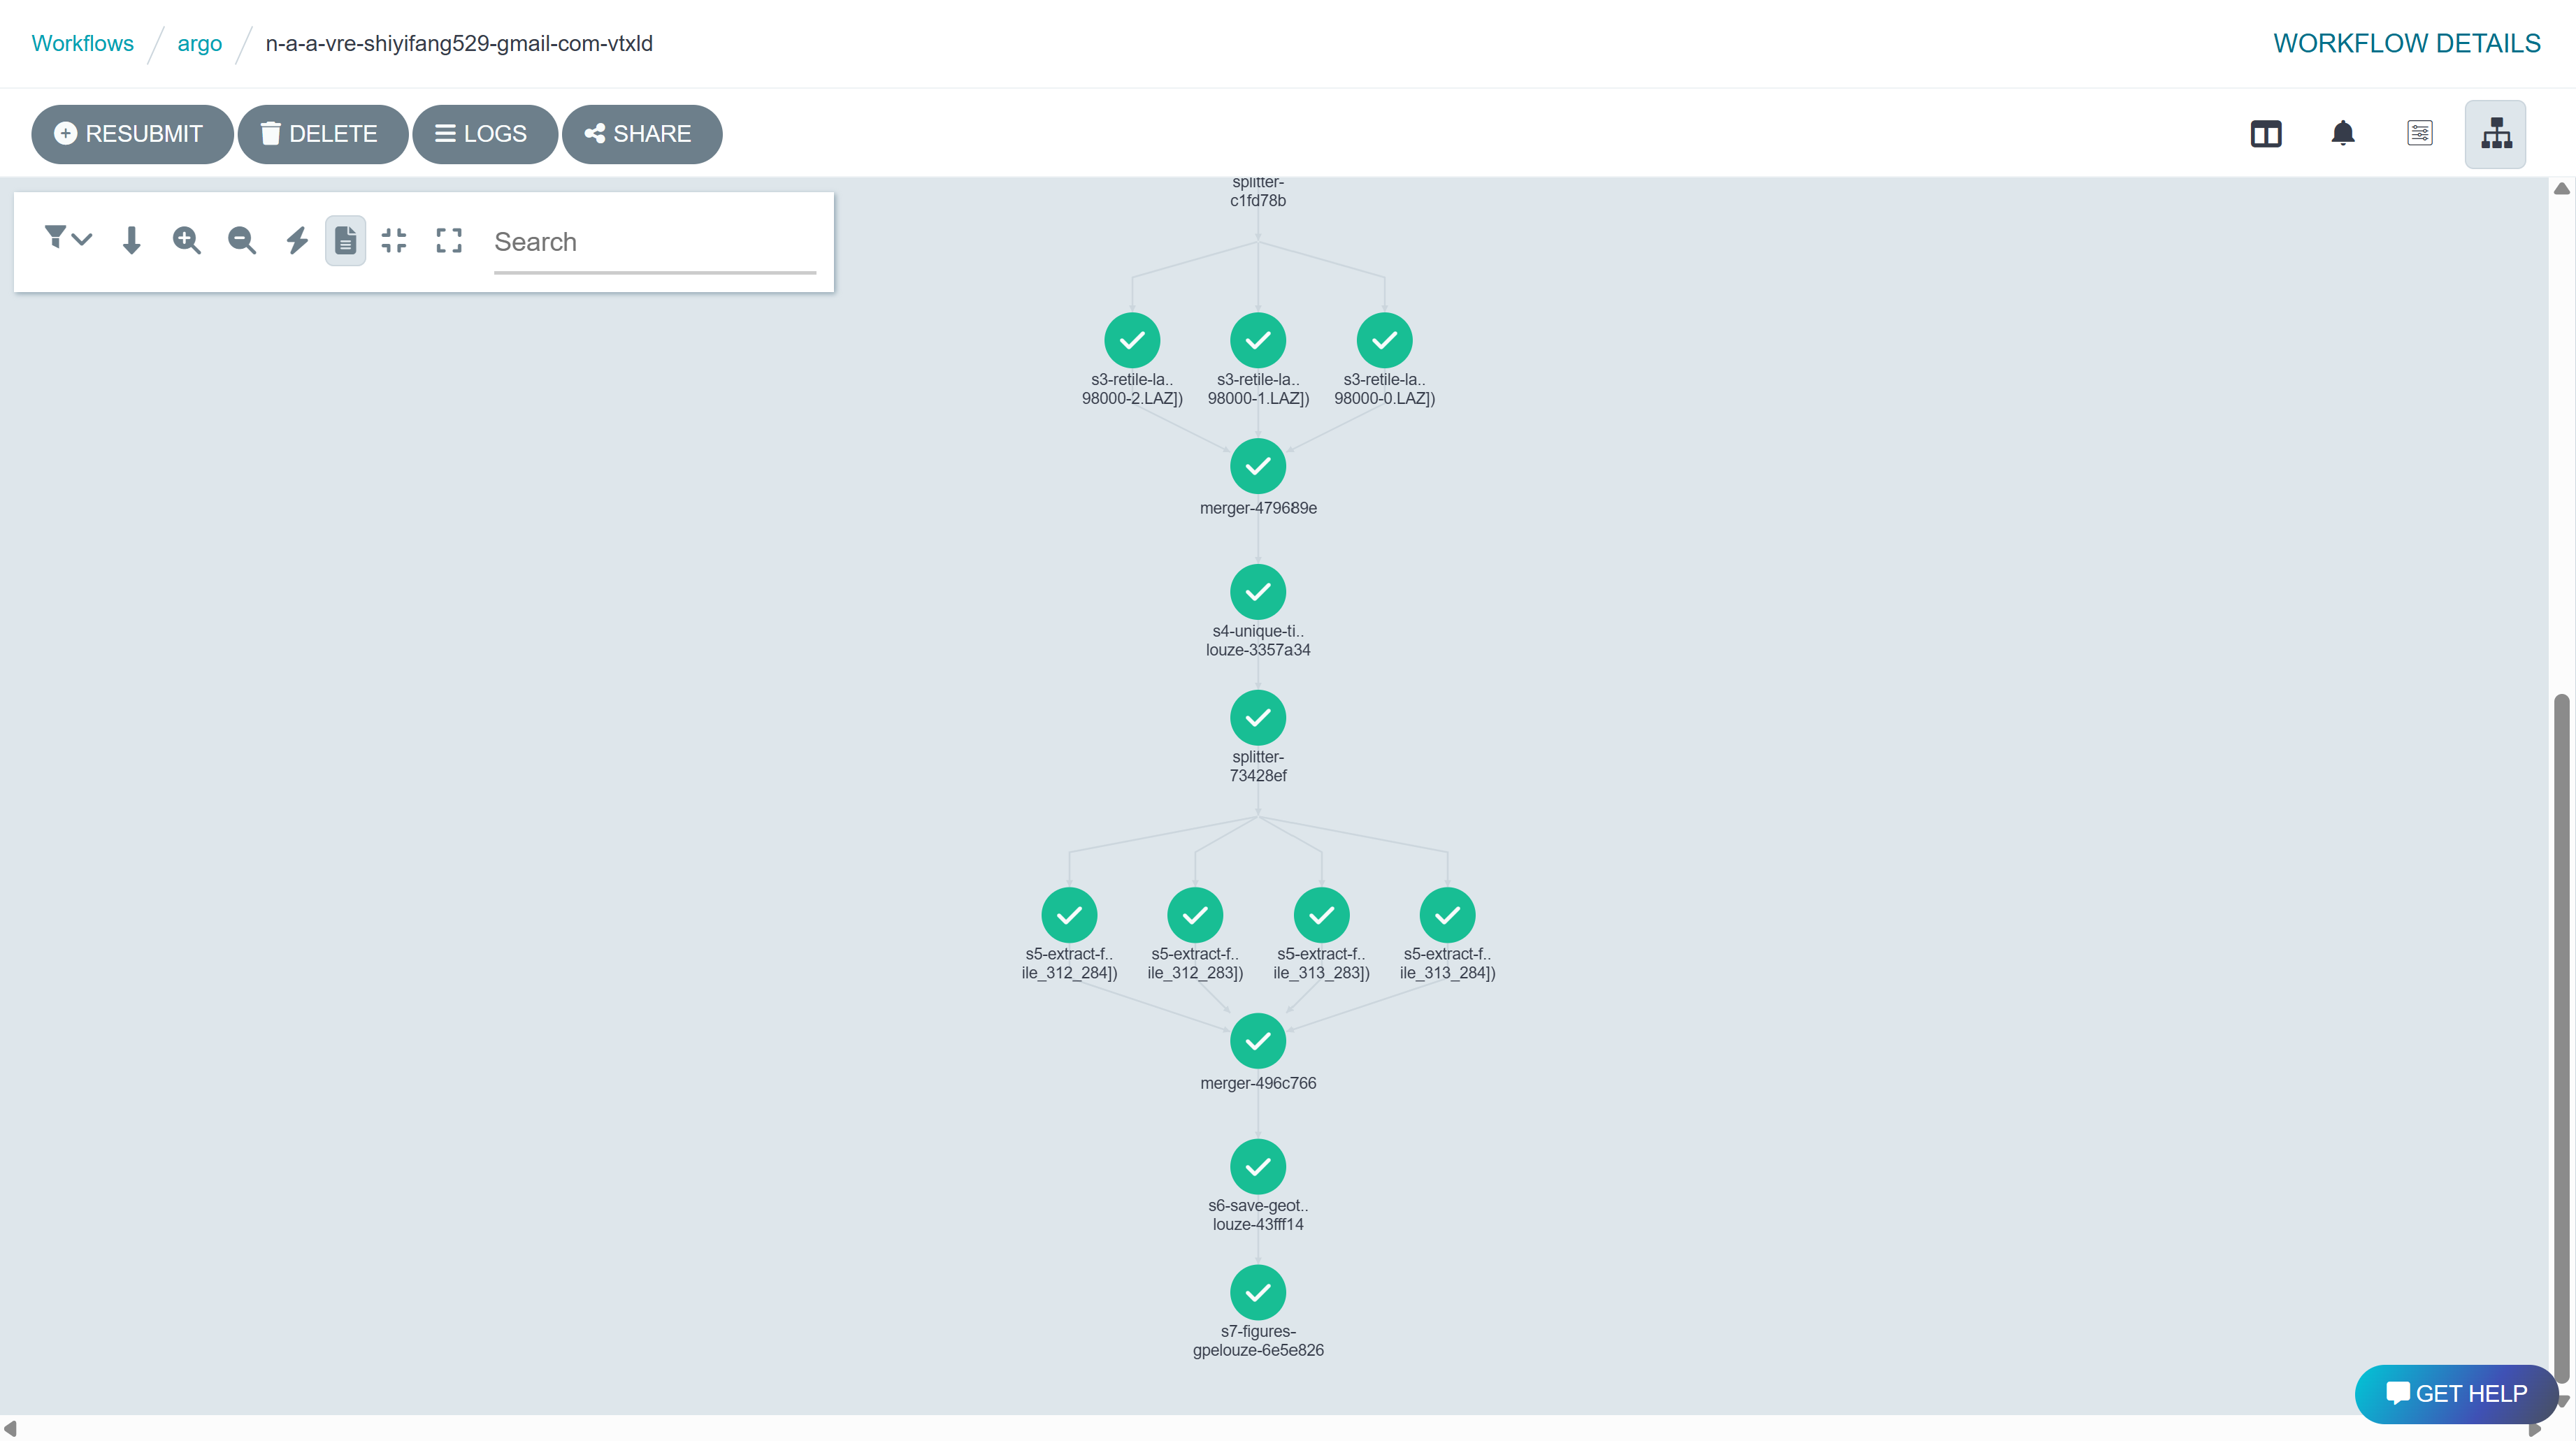

**Workflow failure**: If the workflow did not execute successfully, red crosses will be shown. In that case, click on the red cross of the component that has encountered an error and click on LOGS. Inspect the logs and try to fix the error by changing the parameters of the workflow run.

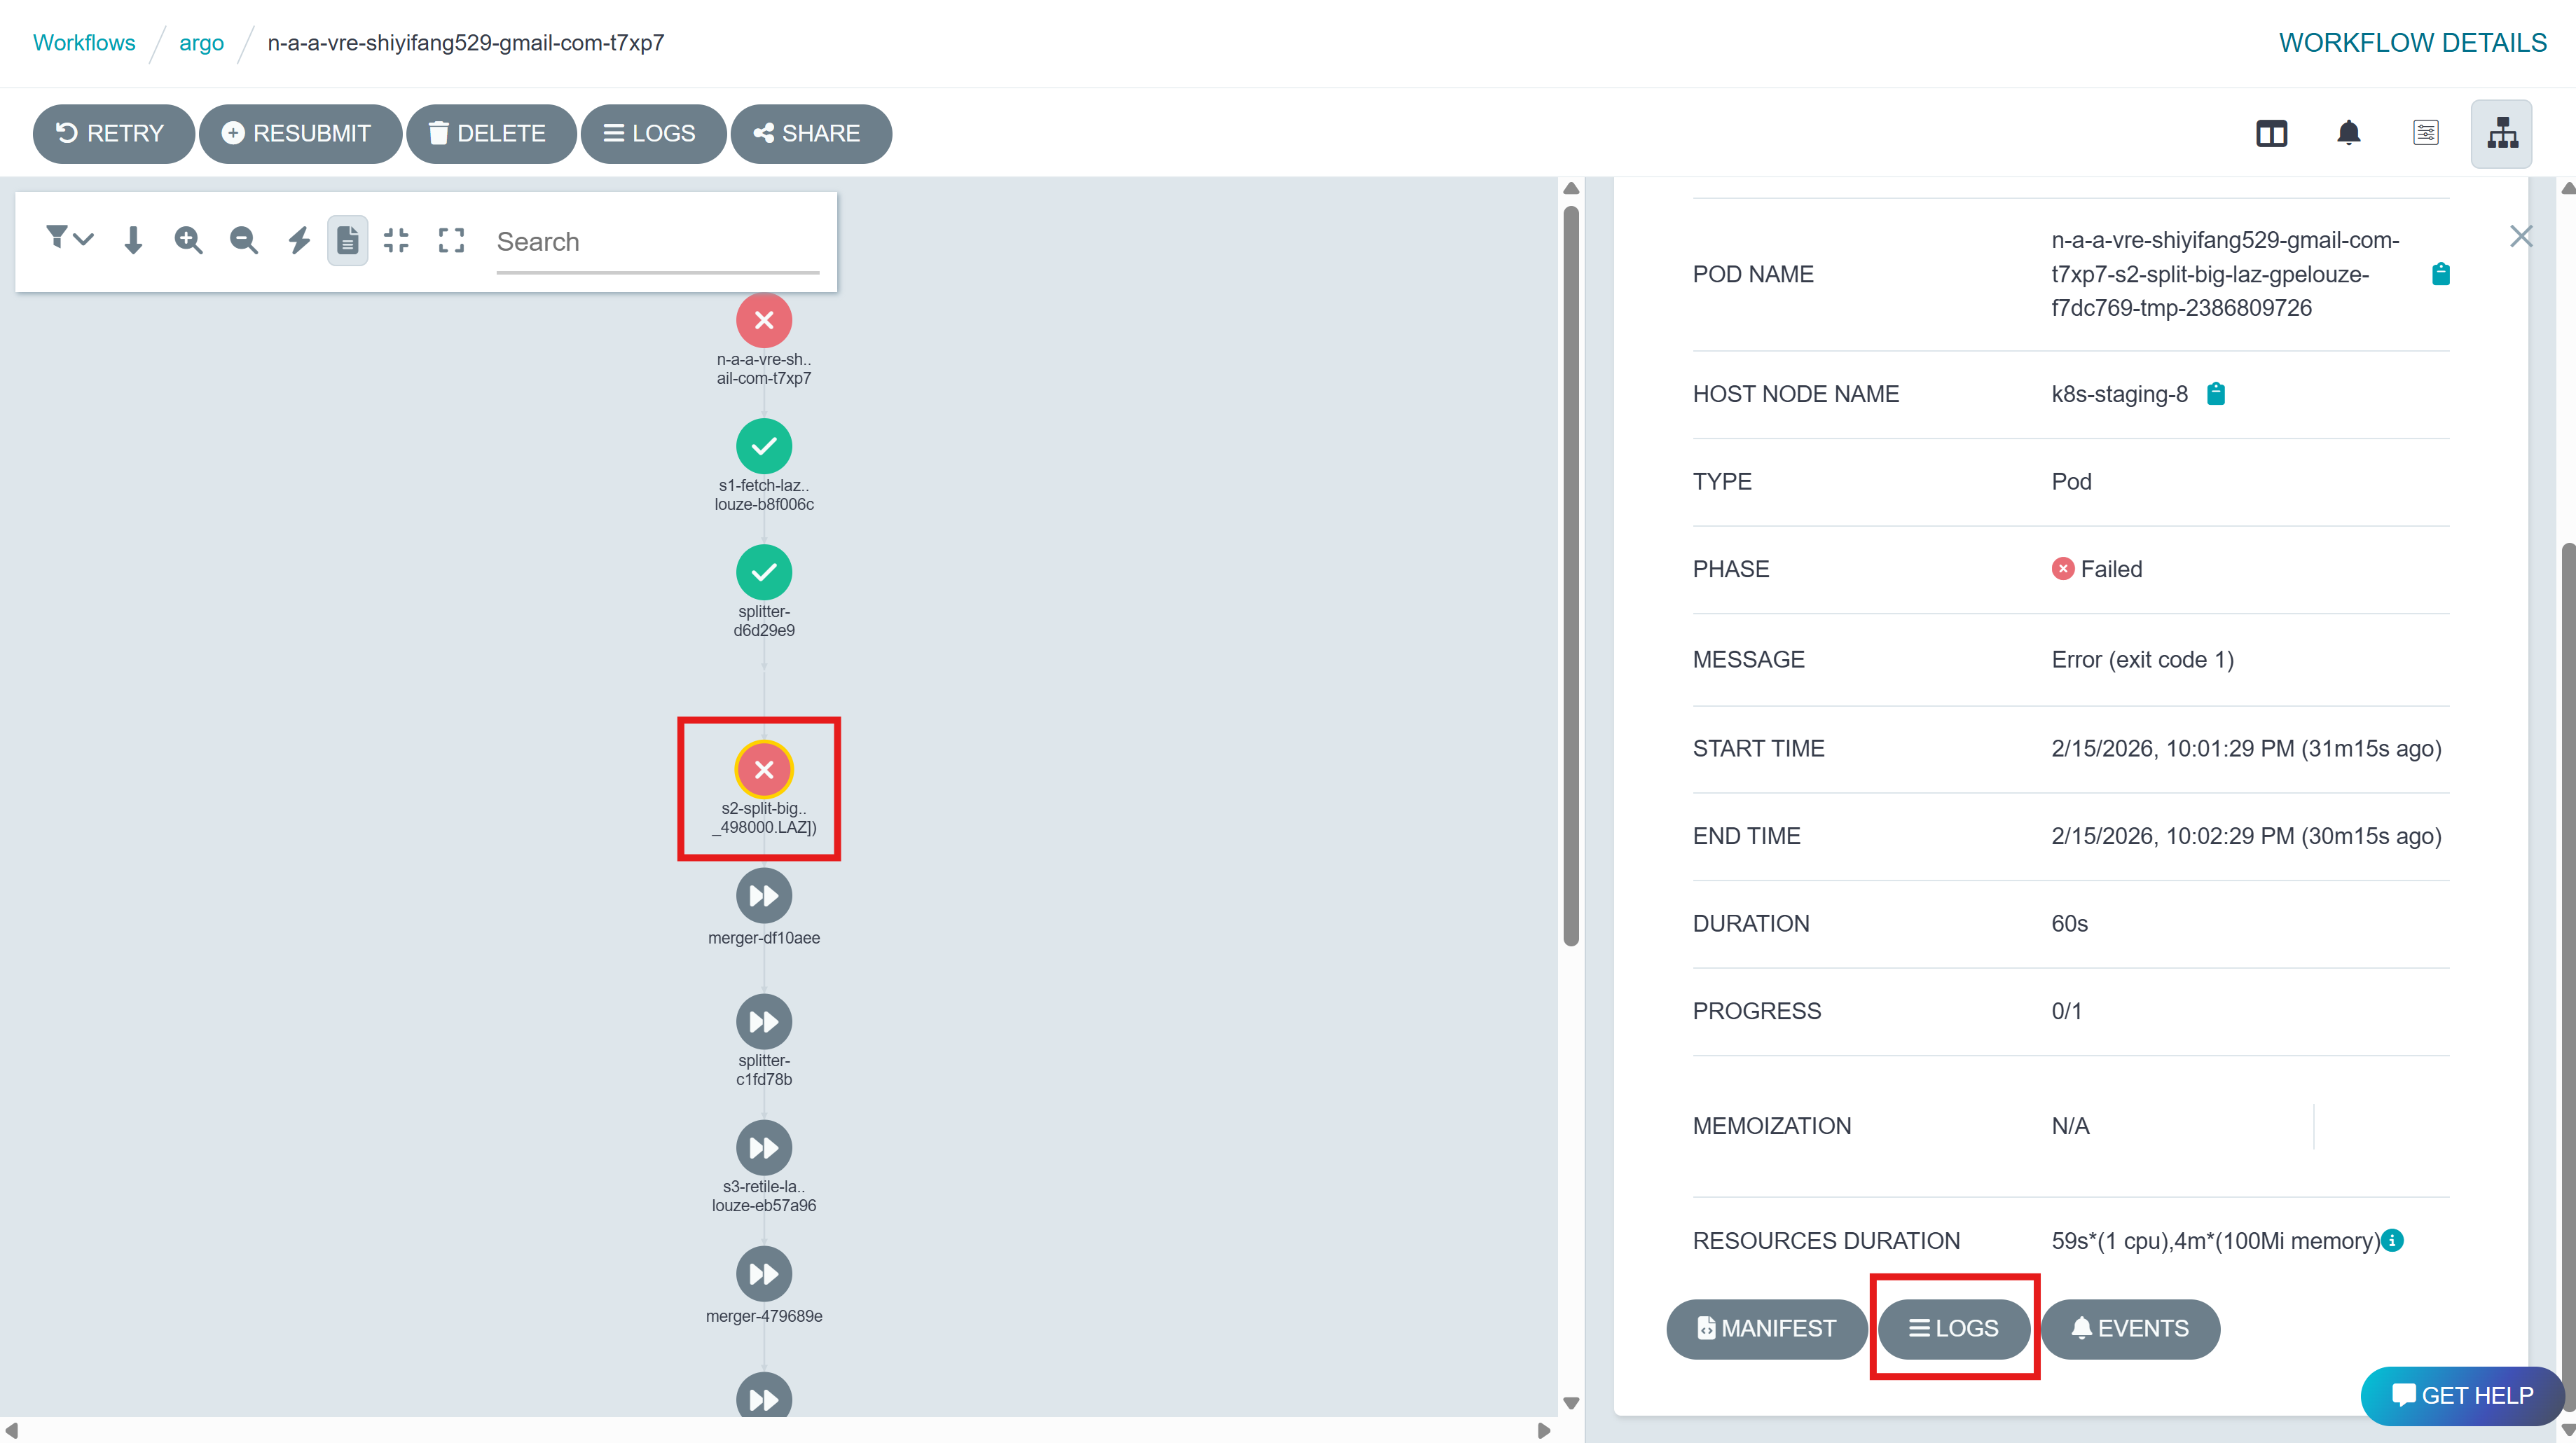

If your workflow complete successfully, you can find the generated GeoTIFF file and created figure (PDF file) on MinIO. 

Go to https://scruffy.lab.uvalight.net:9001/login. 

Log in with the same credentials as you've used to log in to NaaVRE (SSO, or username and password).

You should see the following on your screen:

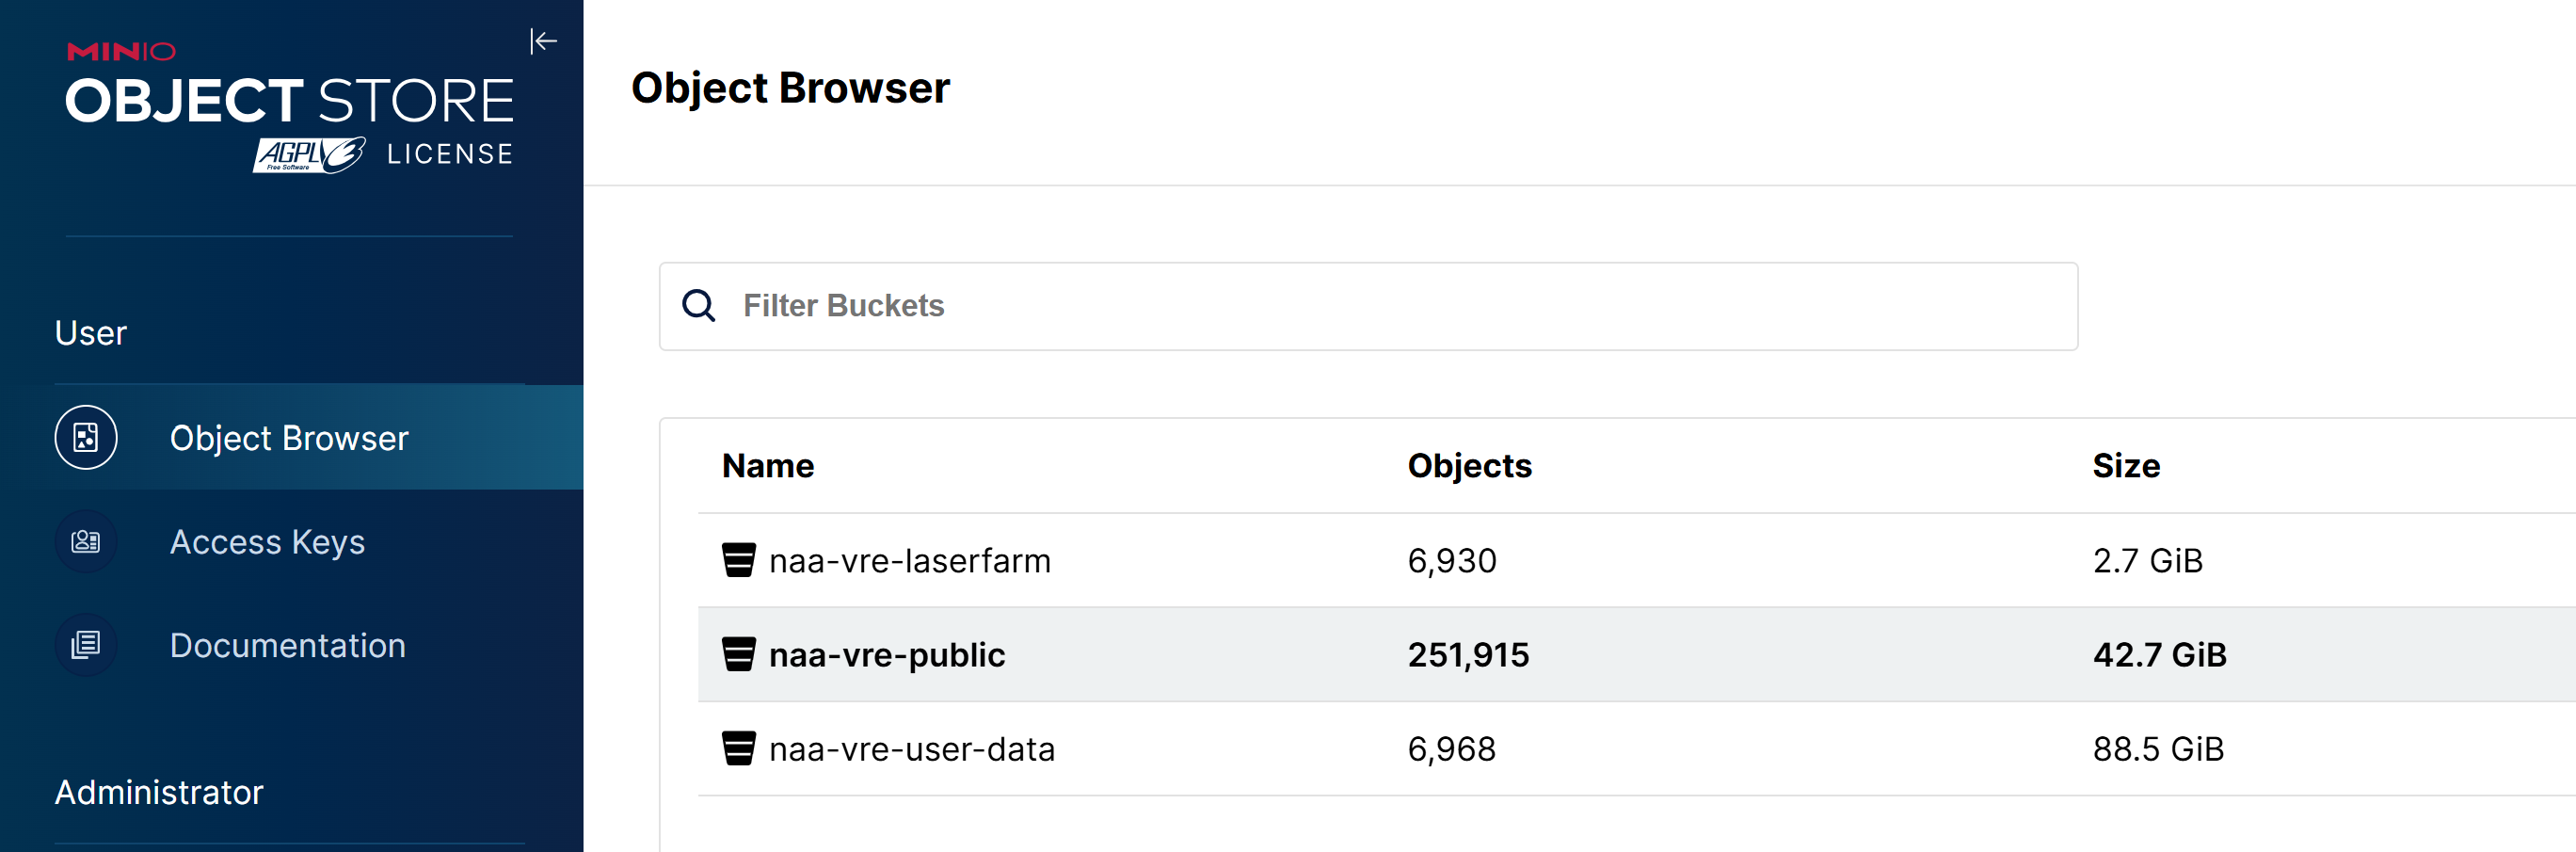

Navigate to folder **naa-vre-user-data/[the e-mail address you used to log into NaaVRE]**. Browse through the directories and see if your expected output files are there. You should find two subfolders: (1) geotiff, where extracted LiDAR metrics are stored in GeoTIFF format, and (2) figures, where a PDF file of the GeoTIFF layer were generated for visualization.

### Additional Exercise

### 1. Can you extract features from two different AHN datasets and calculate vegetation changes using the containerization technique in NaaVRE? 

### 2. Can you adjust and run the workflow using a different LiDAR dataset?